<font size = 20>Feature Engineering & Modelisation</font>

## Téléchargement des packages

In [ ]:
#importing Useful DataStructures
import pandas as pd
import numpy as np
from scipy.stats import uniform

#importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

#importing Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV

#other modelling libraries
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

In [ ]:
!pip install xgboost

In [ ]:
!pip install lightgbm #bayesian-optimization

In [ ]:
!pip install bayesian-optimization

In [ ]:
!pip install prettytable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Scoring-Projet/data

 application_test.csv
 application_test_preprocessed.pkl
 application_train.csv
 Application_train_grouped_interactions_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY.pkl
 Application_train_grouped_interactions_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE.pkl
 Application_train_grouped_interactions_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE.pkl
 Application_train_grouped_interactions_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE.pkl
 Application_train_grouped_interactions_NAME_EDUCATION_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE.pkl
 Application_train_grouped_interactions_OCCUPATION_TYPE_ORGANIZATION_TYPE.pkl
 application_train_preprocessed.pkl
 bureau_balance.csv
 bureau_balance_preprocessed.pkl
 bureau.csv
 bureau_merged_preprocessed.pkl
 cnt_payment_predictor_lgbmr.pkl
 columns_for_ext_values_predictor.pkl
 credit_card_balance.csv
 credit_card_balance_preprocessed.pkl
 Dominant_Class_Model.csv
 Extra_Trees_CV_Preds.pkl
 Extra_Trees_Model.pkl
 Extra_Trees_Test_Preds.pkl
 final_cols.

## Utility Functions and Classes

In [ ]:
def reduce_mem_usage(data, verbose = True):
    #source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''

    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))

    for col in data.columns:
        col_type = data[col].dtype

        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)

    return data

In [ ]:
def relational_tables_prepare(file_directory = '', verbose = True):
    '''
    Function to pickle the relational tables which would need to be merged during production with the
    test datapoint

    Inputs:
        file_directory: str, default = ''
            The directory in which files are saved
        verbose: bool, default = True
            Whether to keep verbosity or not

    Returns:
        None
    '''

    if verbose:
        print("Loading the tables into memory...")
        start = datetime.now()

    #loading all the tables in memory, for dimensionality reduction
    with open(file_directory + 'bureau_merged_preprocessed.pkl', 'rb') as f:
        bureau_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'previous_application_preprocessed.pkl', 'rb') as f:
        previous_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'installments_payments_preprocessed.pkl', 'rb') as f:
        installments_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'POS_CASH_balance_preprocessed.pkl', 'rb') as f:
        pos_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'credit_card_balance_preprocessed.pkl', 'rb') as f:
        cc_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'application_train_preprocessed.pkl', 'rb') as f:
        application_train = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'application_test_preprocessed.pkl', 'rb') as f:
        application_test = reduce_mem_usage(pickle.load(f), verbose = False)

    if verbose:
        print("Done.")
        # print(f"Time Elapsed = {datetime.now() - start2}")
        print("\nMerging all the tables, and saving to pickle file 'relational_table.pkl'...")

    #merging all the tables
    relational_table = cc_aggregated.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = reduce_mem_usage(relational_table, verbose = False)

    with open(file_directory + 'relational_table1.pkl', 'wb') as f:
        pickle.dump(relational_table, f)

    if verbose:
        print("Done.")
        print(f"Total Time taken = {datetime.now() - start}")

In [ ]:
class modelling:
    '''
    Class for Doing Hyperparameter tuning to find best set of hyperparameters, building models on best hyperparams and
    displaying results on best hyperparameters.

    It has 4 methods:
        1. init method
        2. random_search_cv method
        3. train_on_best_params method
        4. proba_to_class method
        5. tune_threshold method
        6. results_on_best_params method
        7. feat_importances_show method
    '''
    def __init__(self, base_model, x_train, y_train, x_test, calibration = False, calibration_method = 'isotonic',
                 calibration_cv = 4, k_folds = 4, random_state = 982):
        '''
        Function to initialize the class members.

        Inputs:
            self
            base_model: estimator/classifier
                The base model to be used for the modelling purpose
            x_train: numpy array
                Training standardized data
            y_train: numpy array
                Training class labels
            x_test: numpy array
                Test standardized data
            calibration: bool, default = False
                Whether to calibrate the model for generating class probabilities
            calibration_method: str, default = 'isotonic'
                The type of calibration to use, i.e. sigmoid or isotonic
            calibration_cv: int, default = 4
                Number of cross-validation folds for calibrating the probabilities
            k_folds: int, default = 4
                Number of cross-validation folds for training and tuning the model
            random_state: int, default = 982
                Random state for StratifiedKFold for reproducibility

        Returns:
            None
        '''
        self.base_model = base_model
        self.num_folds = k_folds
        self.kfolds = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = random_state)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.calibration = calibration
        if self.calibration:
            self.calibration_method = calibration_method
            self.calibration_cv = calibration_cv

    def random_search_cv(self, hyperparams_dict, n_iter = 30, verbose = True, n_jobs = 1, random_state = 843):
        '''
        Function to do RandomizedSearchCV on training data.

        Inputs:
            self
            hyperparams_dict: dict
                Dictionary of hyperparameters to tune
            n_iter: int, default = 30
                Number of iterations to perform for random search
            verbose: bool, default = True
                Whether to keep verbosity or not
            n_jobs: int, default = 1
                Number of cores to use for Random Search
            random_state: int, default = 843
                Random state for reproducibility of RandomizedSearchCV

        Returns:
            None
        '''

        if verbose:
            start = datetime.now()
            print(f"Doing Randomized Search CV on Classifier with {n_iter} random initializations...")
        rscv = RandomizedSearchCV(self.base_model, hyperparams_dict, n_iter = n_iter, scoring = 'roc_auc',
                                  cv = self.kfolds, return_train_score = True, verbose = 2,
                                  n_jobs = n_jobs, random_state = random_state)
        rscv.fit(self.x_train, self.y_train)
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")

        #getting the Search Results
        self.tuning_results = pd.DataFrame(rscv.cv_results_)
        #best model
        self.best_model = rscv.best_estimator_

        gc.collect()

    def train_on_best_params(self, verbose = True):
        '''
        Function to train the model on best hyperparameters obtained from previous method.
        Generates Cross-Validation predictions as Out-of-fold predictions

        Inputs:
            self
            verbose: bool, default = True
                Whether to keep verbosity or not

        Returns:
            None
        '''

        if verbose:
            print("Fitting Classifier on best parameters\n")
            print(f"{self.num_folds}-Fold Cross Validation")
            start = datetime.now()

        self.cv_preds_probas = np.zeros(self.x_train.shape[0])
        #we will select a best threshold for each fold of cross-validation and average over the
        #folds to find the optimal threshold
        self.best_threshold_train = 0
        for fold_number, (train_indices, val_indices) in enumerate(self.kfolds.split(self.x_train, self.y_train), 1):
            if verbose:
                print(f"\tFitting Fold {fold_number}")

            self.best_model.fit(self.x_train[train_indices], self.y_train[train_indices])
            if not self.calibration:
                self.train_preds_probas = self.best_model.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.best_model.predict_proba(self.x_train[val_indices])[:,1]
            else:
                #fitting the calibration Classifier over the base model for calibrated probabilities
                self.calibrated_classifier = CalibratedClassifierCV(self.best_model, method = self.calibration_method, cv = self.calibration_cv)
                self.calibrated_classifier.fit(self.x_train[train_indices], self.y_train[train_indices])

                self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.calibrated_classifier.predict_proba(self.x_train[val_indices])[:,1]

            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_probas) / self.num_folds

        #converting the class probabilities to class labels
        self.cv_preds_class = self.proba_to_class(self.cv_preds_probas, self.best_threshold_train)

        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")

        gc.collect()


    def proba_to_class(self, proba, threshold):
        return np.where(proba >= threshold, 1, 0).astype(int)


    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label

        Returns:
            Threshold probability.
        '''
        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)

        return threshold[index_for_best_threshold]

    def results_on_best_params(self, model_name):
        '''
        Function to train the whole data on best parameters and display the results.

        Inputs:
            self
            model_name: str
                model name to get feature importances.

        Returns:
            None
        '''
        #we have to fit the whole model for optimal test predictions
        self.best_model.fit(self.x_train, self.y_train)
        if not self.calibration:
            self.train_preds_probas = self.best_model.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.best_model.predict_proba(self.x_test)[:,1]
        else:
            #fitting calibration model over whole training data for test predictions
            self.calibrated_classifier.fit(self.x_train, self.y_train)
            self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.calibrated_classifier.predict_proba(self.x_test)[:,1]

        #getting class labels from probabilities
        self.train_preds_class = self.proba_to_class(self.train_preds_probas, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_probas, self.best_threshold_train)

        #feature importances
        if model_name == 'linear':
            self.feat_imp = self.best_model.coef_[0]
        else:
            self.feat_imp = self.best_model.feature_importances_

        print("=" * 100)
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        print("Train Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        print('=' * 100)
        print("Confusion Matrix of CV data:")
        conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
        conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
        plt.figure(figsize = (7,6))
        plt.title('Confusion Matrix Heatmap')
        sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
        plt.show()
        print('=' * 100)

        print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
        plt.figure(figsize=(18, 5))
        colors_ = ['#1f77b4', '#ff7f0e']
        for i, (title, data) in enumerate([
            ("Original Labels", self.y_train),
            ("CV Predictions", self.cv_preds_class),
            ("Test Predictions", self.test_preds_class)]):
            plt.subplot(1, 3, i + 1)
            sns.countplot(x=data, palette=colors_)
            plt.title(title)

        print('=' * 100)


    def feat_importances_show(self, feature_names, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.

        Inputs:
            self
            feature_names: numpy array
                Names of features of training set
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed

        Returns:
            None
        '''

        #getting the top features indices and their names
        top_feats_indices = np.argsort(self.feat_imp)[::-1][:num_features]
        indices = np.argsort(self.feat_imp)[-num_features:][::-1]
        plt.figure(figsize=figsize)
        sns.barplot(x=self.feat_imp[indices], y=feature_names[indices])
        plt.title(f"Top {num_features} Important Features")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.grid(False)
        plt.show()
        print('=' * 100)

        gc.collect()

In [ ]:
class Boosting:
    '''
    Class for Boosting Ensembles and displaying results. Contains 6 methods:

        1. init method
        2. train method
        3. proba_to_class method
        4. tune_threshold method
        5. results method
        6. feat_importance_show
    '''

    def __init__(self, x_train, y_train, x_test, params, num_folds = 3, random_state = 33, verbose = True, save_model_to_pickle = False):
        '''
        Function to initialize the class members.

        Inputs:
            self
            x_train: DataFrame
                Training DataFrame
            y_train: DataFrame
                Training Class labels
            x_test: DataFrame
                Test DataFrame
            params: dict
                Parameters for the boosting ensemble
            num_folds: int, default = 3
                Number of folds for k-Fold Cross Validation
            random_state: int, default = 33
                Random State for Splitting the data for K-Fold Cross Validation
            verbose: bool, default = True
                Whether to keep verbosity or not
            save_model_to_pickle: bool, default = False
                Whether to save the model to pickle file or not

        Returns:
            None
        '''

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.params = params
        self.num_folds = num_folds
        self.stratified_cv = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_state)
        self.verbose = verbose
        self.save_model = save_model_to_pickle

    def train(self, booster, verbose = 400, early_stopping = 200, pickle_name = ''):
        '''
        Function to train the Classifier on given parameters. It fits the classifier for each fold, and for Cross Validation,
        uses Out-of-Fold Predictions. The test predictions are averaged predictions over each fold.

        Inputs:
            self
            booster: str
                Whether the booster is 'xgboost' or 'lightgbm'
            verbose: int, default = 400
                Number of boosting rounds for printint boosting results.
            early_stopping: int, default = 200
                Number of boosting rounds to look for early stopping
            pickle_name: str, default = ''
                The string to add to end of pickle file of model, if any

        Returns:
            None
        '''

        self.train_preds_proba_mean = np.zeros(self.x_train.shape[0])
        #out-of-fold cv predictions
        self.cv_preds_proba = np.zeros(self.x_train.shape[0])
        self.test_preds_proba_mean = np.zeros(self.x_test.shape[0])
        #best threshold will be
        self.best_threshold_train = 0
        self.feature_importance = pd.DataFrame()
        self.feature_importance['features'] = self.x_train.columns
        self.feature_importance['gain'] = np.zeros(self.x_train.shape[1])

        if self.verbose:
            print(f"Fitting the {booster} on Training Data with {self.num_folds} fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation")
            start = datetime.now()

        for fold_number, (train_indices, cv_indices) in enumerate(self.stratified_cv.split(self.x_train, self.y_train), 1):
            if self.verbose:
                print(f"\n\tFold Number {fold_number}\n")

            x_tr = self.x_train.iloc[train_indices]
            y_tr = self.y_train.iloc[train_indices]
            x_cv = self.x_train.iloc[cv_indices]
            y_cv = self.y_train.iloc[cv_indices]

            if booster == 'xgboost':
                clf = XGBClassifier(**self.params)
            else:
                clf = LGBMClassifier(**self.params)

            clf.fit(x_tr, y_tr, eval_set = [(x_tr, y_tr), (x_cv, y_cv)], eval_metric = 'auc',
                     verbose = verbose, early_stopping_rounds = 200)

            if booster == 'xgboost':
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, ntree_limit = clf.get_booster().best_ntree_limit)[:, 1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, ntree_limit = clf.get_booster().best_ntree_limit)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, ntree_limit = clf.get_booster().best_ntree_limit)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.get_booster().get_score(importance_type = 'gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = gain_fold.keys()
                feat_imp['gain'] = gain_fold.values()

            else:
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, num_iteration = clf.best_iteration_)[:,1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, num_iteration = clf.best_iteration_)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, num_iteration = clf.best_iteration_)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.booster_.feature_importance(importance_type='gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = self.x_train.columns
                feat_imp['gain'] = gain_fold

            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_proba_mean[train_indices]) / self.num_folds
            #concatenating the feature importance of each fold to original df
            self.feature_importance = pd.concat([self.feature_importance, feat_imp], axis = 0)

            if self.save_model:
                #saving the model into a pickle file
                with open(f'clf_{booster}_fold_{fold_number}_model_{pickle_name}.pkl', 'wb') as f:
                    pickle.dump(clf, f)

        #mean feature importance averaged over all folds
        self.feature_importance = self.feature_importance.groupby('features', as_index = False).mean()
        #sorting the feature importance
        self.feature_importance = self.feature_importance.sort_values(by = 'gain', ascending = False)

        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        gc.collect()

    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.

        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label

        Returns:
            Converted Class Label
        '''

        return np.where(proba >= threshold, 1, 0)

    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label

        Returns:
            Threshold probability.
        '''

        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)

        return threshold[index_for_best_threshold]

    def results(self, roc_auc = True, precision_recall = True, confusion_matrix = True, cv_test_distribution = False):
        '''
        Function to display the final results of Train, CV and Test Dataset.

        Inputs:
            self

        Returns:
            None
        '''

        #getting the crisp class labels
        self.train_preds_class = self.proba_to_class(self.train_preds_proba_mean, self.best_threshold_train)
        self.cv_preds_class = self.proba_to_class(self.cv_preds_proba, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_proba_mean, self.best_threshold_train)
        print("=" * 100)
        print("Train Results:")
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_proba_mean)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_proba)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        if confusion_matrix:
            print('=' * 100)
            print("Confusion, Precision and Recall Matrix on CV data:")
            conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
            conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
            plt.figure(figsize = (7,6))
            plt.title('Confusion Matrix Heatmap')
            sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
            plt.show()

        if cv_test_distribution:
            print('=' * 100)
            print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
            plt.figure(figsize = (20,6))
            plt.subplot(1,3,1)
            plt.title('Class Distribution of Original Dataset')
            sns.countplot(self.y_train)
            plt.subplot(1,3,2)
            plt.title('Class Distribution of predicted Class Labels on CV')
            sns.countplot(self.cv_preds_class)
            plt.subplot(1,3,3)
            plt.title('Class Distribution of predicted Test Dataset')
            sns.countplot(self.test_preds_class)
            plt.show()
        print('=' * 100)

        gc.collect()

    def feat_importances_show(self, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.

        Inputs:
            self
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed

        Returns:
            None
        '''

        plt.figure(figsize = figsize)
        sns.barplot(self.feature_importance['gain'].iloc[:num_features], self.feature_importance['features'].iloc[:num_features], orient = 'h')
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)

        gc.collect()

# Data Cleaning and Feature Engineering

The data contains several number of relational tables. We'll process each one of them separately, and then finally in the end, merge all of them together.

## Preprocessing Tables

### bureau_balance.csv and bureau.csv

Ces tables contiennent des informations relatives aux crédits antérieurs des clients, qui n’étaient pas contractés auprès de Home Credit Group, mais rapportés par le département du Bureau de Crédit.

<ol> <li><b>bureau_balance</b> <ol> <li>Tout d'abord, la table <code>bureau_balance</code> contient trois champs : <code>SK_ID_BUREAU</code>, <code>MONTHS_BALANCE</code> et <code>STATUS</code>.</li>
  <li>Comme la variable <code>STATUS</code> présente un comportement plutôt ordinal, on commence par l’encoder avec un <b>Label Encoding</b>.</li>
  <li>Ensuite, certaines variables sont créées, comme le <b>status pondéré</b>, obtenu en divisant le statut par <code>MONTHS_BALANCE</code>.</li>
  <li>Étant donné que ces données sont de type séries temporelles, nous calculons aussi la <b>moyenne mobile exponentielle</b (EWMA) du <code>STATUS</code> et du <code>STATUS pondéré</code>.</li>
  <li>Enfin, nous agrégeons les données par <code>SK_ID_BUREAU</code>. Nous effectuons d’abord une agrégation sur toutes les données disponibles, puis une agrégation spécifique sur les deux dernières années, afin de représenter le comportement récent du client.</li>
  <li>Les agrégations sont basées sur des connaissances métier, et comprennent : <b>moyenne (mean), minimum (min), maximum (max), somme (sum), comptage (count)</b>, etc.  
  Pour les variables utilisées dans l’analyse exploratoire (EDA), nous ne retenons que les dernières valeurs, car elles reflètent généralement la tendance globale.</li></ol>

</li> <li><b>bureau</b>
<ol><li>Tout d’abord, nous fusionnons la table <code>bureau</code> avec la table <code>bureau_balance</code> agrégée à l’étape précédente, en utilisant la clé <code>SK_ID_BUREAU</code>.</li>
  <li>Nous remplaçons certaines valeurs erronées par des <code>NaN</code>. Par exemple, certains prêts remontent à plus de 100 ans. Nous estimons que ces données n'apportent pas d’information pertinente sur le comportement récent du client. Nous conservons donc uniquement les crédits datant de moins de 50 ans.</li>
  
  <li>De nouvelles variables sont générées par des multiplications, divisions et soustractions entre les variables brutes, en s’appuyant sur notre expertise métier. Par exemple : <b>durée du crédit</b>, <b>ratio annuité/crédit</b>, etc.</li>
  
  <li>Les variables catégorielles sont transformées en <b>variables indicatrices (encodage one-hot)</b>.</li>
  
  <li>Pour intégrer ces données dans la table principale (<code>application_train</code>), nous agrégeons cette table par <code>SK_ID_CURR</code>.  
    L’agrégation est réalisée en deux étapes :
    <ul>
      <li>D’abord, les crédits sont regroupés selon la catégorie <code>CREDIT_ACTIVE</code>, et deux catégories sont traitées séparément : <b>Active</b> et <b>Closed</b>.</li>
      <li>Les autres catégories sont ensuite agrégées, puis toutes les données sont fusionnées.</li>
      <li>Une agrégation globale sur toutes les données est également réalisée.</li>
    </ul>
    Les statistiques utilisées pour l’agrégation incluent : <b>somme, moyenne, minimum, maximum, dernière valeur (last)</b>, etc.
  </li>
</ol>

            

In [ ]:
bureau_balance = pd.read_csv('/content/drive/MyDrive/Scoring-Projet/data/bureau_balance.csv')

In [ ]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
t = bureau_balance['MONTHS_BALANCE']/-12

In [ ]:
t.max()

np.float64(8.0)

In [ ]:
import pickle

# Ouvre le fichier en mode binaire
with open('/content/drive/MyDrive/Scoring-Projet/data/bureau_balance_preprocessed.pkl', 'rb') as f:
   test = pickle.load(f)

test.head()

,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_MAX,STATUS_MEAN,STATUS_MAX,STATUS_FIRST,WEIGHTED_STATUS_MEAN,WEIGHTED_STATUS_SUM,WEIGHTED_STATUS_FIRST,EXP_ENCODED_STATUS_LAST,EXP_WEIGHTED_STATUS_LAST,...,STATUS_MEAN_YEAR_REST,STATUS_MAX_YEAR_REST,STATUS_LAST_YEAR_REST,STATUS_FIRST_YEAR_REST,WEIGHTED_STATUS_MEAN_YEAR_REST,WEIGHTED_STATUS_MAX_YEAR_REST,WEIGHTED_STATUS_FIRST_YEAR_REST,WEIGHTED_STATUS_LAST_YEAR_REST,EXP_WEIGHTED_STATUS_LAST_YEAR_REST,EXP_ENCODED_STATUS_LAST_YEAR_REST
SK_ID_BUREAU,,,,,,,,,,,,,,,,,,,,,
5001709,3.546392,8,0.453608,4,4,0.004936,0.478827,0.041237,3.094850e-60,3.547249e-62,...,0.602740,4.0,0.0,4.0,0.006559,0.045977,0.041237,0.0,2.114325e-45,1.844674e-43
5001710,2.963855,6,1.506024,4,4,0.022689,1.883185,0.048193,4.166370e-34,8.419081e-36,...,2.118644,4.0,0.0,4.0,0.031918,0.080000,0.048193,0.0,5.018163e-19,2.483350e-17
5001711,0.000000,0,1.750000,4,1,1.270833,5.083333,0.250000,3.403846e+00,3.297543e+00,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00
5001712,0.368421,1,0.526316,1,1,0.037830,0.718771,0.052632,5.119999e-07,5.008223e-08,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00
5001713,0.454545,1,4.000000,4,4,0.671057,14.763253,0.181818,4.000000e+00,3.570297e+00,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00


In [ ]:
class preprocess_bureau_balance_and_bureau:
    '''
    Preprocess the tables bureau_balance and bureau.
    Contains 4 member functions:
        1. init method
        2. preprocess_bureau_balance method
        3. preprocess_bureau method
        4. main method
    '''

    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members

        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not

        Returns:
            None
        '''

        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        self.start = datetime.now()

    def preprocess_bureau_balance(self):
        '''
        Function to preprocess bureau_balance table.
        This function first loads the table into memory, does some feature engineering, and finally
        aggregates the data over SK_ID_BUREAU

        Inputs:
            self

        Returns:
            preprocessed and aggregated bureau_balance table.
        '''

        if self.verbose:
            print('#######################################################')
            print('#          Pre-processing bureau_balance.csv          #')
            print('#######################################################')
            print("\nLoading the DataFrame, bureau_balance.csv, into memory...")

        bureau_balance = pd.read_csv(self.file_directory + 'bureau_balance.csv')

        if self.verbose:
            print("Loaded bureau_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
            print("\nStarting Data Cleaning and Feature Engineering...")

        #as we saw from EDA, bureau_balance has a variable called STATUS, which describes about the status of loan.
        #it has 7 labels, we will label encode them
        #so we give C as 0, and rest increasing
        #also we will give X the benefit of doubt and keep it as middle value
        dict_for_status = { 'C': 0, '0': 1, '1': 2, '2': 3, 'X': 4, '3': 5, '4': 6, '5': 7}
        bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_for_status)

        #weighing the status with the months_balance
        #converting months to positive
        bureau_balance['MONTHS_BALANCE'] = np.abs(bureau_balance['MONTHS_BALANCE'])
        bureau_balance['WEIGHTED_STATUS'] = bureau_balance.STATUS / (bureau_balance.MONTHS_BALANCE + 1)

        #sorting the bureau_balance in ascending order of month and by the bureau SK_ID
        #this is done so as to make the rolling exponential average easily for previous months till current month
        bureau_balance = bureau_balance.sort_values(by=['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=[0, 0])
        #we will do exponential weighted average on the encoded status
        #this is because if a person had a bad status 2 years ago, it should be given less weightage today
        # we keep the latent variable alpha = 0.8
        #doing this for both weighted status and the status itself
        bureau_balance['EXP_WEIGHTED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['WEIGHTED_STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())
        bureau_balance['EXP_ENCODED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())

        if self.verbose:
            print("Halfway through. A little bit more patience...")
            print(f"Total Time Elapsed = {datetime.now() - self.start}")

        #we can see that these datapoints are for 96 months i.e. 8 years.
        #so we will extract the means, and exponential averages for each year separately
        #first we convert month to year
        bureau_balance['MONTHS_BALANCE'] = bureau_balance['MONTHS_BALANCE'] // 12

        #defining our aggregations
        aggregations_basic = {
            'MONTHS_BALANCE' : ['mean','max'],
            'STATUS' : ['mean','max','first'],
            'WEIGHTED_STATUS' : ['mean','sum','first'],
            'EXP_ENCODED_STATUS' : ['last'],
            'EXP_WEIGHTED_STATUS' : ['last']}

        #we will be finding aggregates for each year too
        aggregations_for_year = {
            'STATUS' : ['mean','max','last','first'],
            'WEIGHTED_STATUS' : ['mean','max', 'first','last'],
            'EXP_WEIGHTED_STATUS' : ['last'],
            'EXP_ENCODED_STATUS' : ['last'] }

        #aggregating over whole dataset first
        aggregated_bureau_balance = bureau_balance.groupby(['SK_ID_BUREAU']).agg(aggregations_basic)
        aggregated_bureau_balance.columns = ['_'.join(ele).upper() for ele in aggregated_bureau_balance.columns]

        #aggregating some of the features separately for latest 2 years
        aggregated_bureau_years = pd.DataFrame()
        for year in range(2):
            year_group = bureau_balance[bureau_balance['MONTHS_BALANCE'] == year].groupby('SK_ID_BUREAU').agg(aggregations_for_year)
            year_group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in year_group.columns]

            if year == 0:
                aggregated_bureau_years = year_group
            else:
                aggregated_bureau_years = aggregated_bureau_years.merge(year_group, on = 'SK_ID_BUREAU', how = 'outer')

        #aggregating for rest of the years
        aggregated_bureau_rest_years = bureau_balance[bureau_balance.MONTHS_BALANCE > year].groupby(['SK_ID_BUREAU']).agg(aggregations_for_year)
        aggregated_bureau_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in aggregated_bureau_rest_years.columns]

        #merging with rest of the years
        aggregated_bureau_years = aggregated_bureau_years.merge(aggregated_bureau_rest_years, on = 'SK_ID_BUREAU', how = 'outer')
        aggregated_bureau_balance = aggregated_bureau_balance.merge(aggregated_bureau_years, on = 'SK_ID_BUREAU', how = 'inner')

        #filling the missing values obtained after aggregations with 0
        aggregated_bureau_balance.fillna(0, inplace = True)

        if self.verbose:
            print('Done preprocessing bureau_balance.')
            print(f"\nInitial Size of bureau_balance: {bureau_balance.shape}")
            print(f'Size of bureau_balance after Pre-Processing, Feature Engineering and Aggregation: {aggregated_bureau_balance.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed bureau_balance to bureau_balance_preprocessed.pkl')
            with open(self.file_directory + 'bureau_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(aggregated_bureau_balance, f)
            if self.verbose:
                print('Done.')

        return aggregated_bureau_balance

    def preprocess_bureau(self, aggregated_bureau_balance):
        '''
        Function to preprocess the bureau table and merge it with the aggregated bureau_balance table.
        Finally aggregates the data over SK_ID_CURR for it to be merged with application_train table.

        Inputs:
            self
            aggregated_bureau_balance: DataFrame of aggregated bureau_balance table

        Returns:
            Final preprocessed, merged and aggregated bureau table
        '''

        if self.verbose:
            start2 = datetime.now()
            print('\n##############################################')
            print('#          Pre-processing bureau.csv         #')
            print('##############################################')
            print("\nLoading the DataFrame, bureau.csv, into memory...")

        bureau = pd.read_csv(self.file_directory + 'bureau.csv')

        if self.verbose:
            print("Loaded bureau.csv")
            print(f"Time Taken to load = {datetime.now() - start2}")
            print("\nStarting Data Cleaning and Feature Engineering...")

        #merging it with aggregated bureau_balance on 'SK_ID_BUREAU'
        bureau_merged = bureau.merge(aggregated_bureau_balance, on = 'SK_ID_BUREAU', how = 'left')

        #from the EDA we saw some erroneous values in DAYS Fields, we will remove those
        #there are some loans which ended about very long ago, around 100 years ago.
        #Thus we will only keep those loans which have ended in past 50 years.
        bureau_merged['DAYS_CREDIT_ENDDATE'][bureau_merged['DAYS_CREDIT_ENDDATE'] > -50*365] = np.nan
        bureau_merged['DAYS_ENDDATE_FACT'][bureau_merged['DAYS_ENDDATE_FACT'] > -50*365] = np.nan
        #there is also a feature which tells about the number of days ago the Credit Report Came
        bureau_merged['DAYS_CREDIT_UPDATE'][bureau_merged['DAYS_CREDIT_UPDATE'] > -50*365] = np.nan

        #engineering some features based on domain knowledge
        bureau_merged['CREDIT_DURATION'] = np.abs(bureau_merged['DAYS_CREDIT'] - bureau_merged['DAYS_CREDIT_ENDDATE'])
        bureau_merged['FLAG_OVERDUE_RECENT'] = [0 if ele == 0 else 1 for ele in bureau_merged['CREDIT_DAY_OVERDUE']]
        bureau_merged['MAX_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_MAX_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['AMT_OVERDUE_DURATION_LEFT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['DAYS_CREDIT_ENDDATE'] + 0.00001)
        bureau_merged['CNT_PROLONGED_MAX_OVERDUE_MUL'] = bureau_merged['CNT_CREDIT_PROLONG'] * bureau_merged['AMT_CREDIT_MAX_OVERDUE']
        bureau_merged['CNT_PROLONGED_DURATION_RATIO'] = bureau_merged['CNT_CREDIT_PROLONG'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['CURRENT_DEBT_TO_CREDIT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_DEBT'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
        bureau_merged['CURRENT_CREDIT_DEBT_DIFF'] = bureau_merged['AMT_CREDIT_SUM'] - bureau_merged['AMT_CREDIT_SUM_DEBT']
        bureau_merged['AMT_ANNUITY_CREDIT_RATIO'] = bureau_merged['AMT_ANNUITY'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
        bureau_merged['CREDIT_ENDDATE_UPDATE_DIFF'] = np.abs(bureau_merged['DAYS_CREDIT_UPDATE'] - bureau_merged['DAYS_CREDIT_ENDDATE'])

        #now we will be aggregating the bureau_merged df with respect to 'SK_ID_CURR' so as to merge it with application_train later
        #firstly we will aggregate the columns based on the category of CREDIT_ACTIVE
        aggregations_CREDIT_ACTIVE = {
                        'DAYS_CREDIT' : ['mean','min','max','last'],
                        'CREDIT_DAY_OVERDUE' : ['mean','max'],
                        'DAYS_CREDIT_ENDDATE' : ['mean','max'],
                        'DAYS_ENDDATE_FACT' : ['mean','min'],
                        'AMT_CREDIT_MAX_OVERDUE': ['max','sum'],
                        'CNT_CREDIT_PROLONG': ['max','sum'],
                        'AMT_CREDIT_SUM' : ['sum','max'],
                        'AMT_CREDIT_SUM_DEBT': ['sum'],
                        'AMT_CREDIT_SUM_LIMIT': ['max','sum'],
                        'AMT_CREDIT_SUM_OVERDUE': ['max','sum'],
                        'DAYS_CREDIT_UPDATE' : ['mean','min'],
                        'AMT_ANNUITY' : ['mean','sum','max'],
                        'CREDIT_DURATION' : ['max','mean'],
                        'FLAG_OVERDUE_RECENT': ['sum'],
                        'MAX_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                        'CURRENT_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                        'AMT_OVERDUE_DURATION_LEFT_RATIO' : ['max', 'mean'],
                        'CNT_PROLONGED_MAX_OVERDUE_MUL' : ['mean','max'],
                        'CNT_PROLONGED_DURATION_RATIO' : ['mean', 'max'],
                        'CURRENT_DEBT_TO_CREDIT_RATIO' : ['mean', 'min'],
                        'CURRENT_CREDIT_DEBT_DIFF' : ['mean','min'],
                        'AMT_ANNUITY_CREDIT_RATIO' : ['mean','max','min'],
                        'CREDIT_ENDDATE_UPDATE_DIFF' : ['max','min'],
                        'STATUS_MEAN' : ['mean', 'max'],
                        'WEIGHTED_STATUS_MEAN' : ['mean', 'max']
                         }

        #we saw from EDA that the two most common type of CREDIT ACTIVE were 'Closed' and 'Active'.
        #So we will aggregate them two separately and the remaining categories separately.
        categories_to_aggregate_on = ['Closed','Active']
        bureau_merged_aggregated_credit = pd.DataFrame()
        for i, status in enumerate(categories_to_aggregate_on):
            group = bureau_merged[bureau_merged['CREDIT_ACTIVE'] == status].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
            group.columns = ['_'.join(ele).upper() + '_CREDITACTIVE_' + status.upper() for ele in group.columns]

            if i==0:
                bureau_merged_aggregated_credit = group
            else:
                bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(group, on = 'SK_ID_CURR', how = 'outer')
        #aggregating for remaining categories
        bureau_merged_aggregated_credit_rest = bureau_merged[(bureau_merged['CREDIT_ACTIVE'] != 'Active') &
                                                             (bureau_merged['CREDIT_ACTIVE'] != 'Closed')].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
        bureau_merged_aggregated_credit_rest.columns = ['_'.join(ele).upper() + 'CREDIT_ACTIVE_REST' for ele in bureau_merged_aggregated_credit_rest.columns]

        #merging with other categories
        bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(bureau_merged_aggregated_credit_rest, on = 'SK_ID_CURR', how = 'outer')

        #Encoding the categorical columns in one-hot form
        currency_ohe = pd.get_dummies(bureau_merged['CREDIT_CURRENCY'], prefix = 'CURRENCY')
        credit_active_ohe = pd.get_dummies(bureau_merged['CREDIT_ACTIVE'], prefix = 'CREDIT_ACTIVE')
        credit_type_ohe = pd.get_dummies(bureau_merged['CREDIT_TYPE'], prefix = 'CREDIT_TYPE')

        #merging the one-hot encoded columns
        bureau_merged = pd.concat([bureau_merged.drop(['CREDIT_CURRENCY','CREDIT_ACTIVE','CREDIT_TYPE'], axis = 1),
                                   currency_ohe, credit_active_ohe, credit_type_ohe], axis = 1)

        #aggregating the bureau_merged over all the columns
        bureau_merged_aggregated = bureau_merged.drop('SK_ID_BUREAU', axis = 1).groupby('SK_ID_CURR').agg('mean')
        bureau_merged_aggregated.columns = [ele + '_MEAN_OVERALL' for ele in bureau_merged_aggregated.columns]
        #merging it with aggregates over categories
        bureau_merged_aggregated = bureau_merged_aggregated.merge(bureau_merged_aggregated_credit, on = 'SK_ID_CURR', how = 'outer')

        if self.verbose:
            print('Done preprocessing bureau and bureau_balance.')
            print(f"\nInitial Size of bureau: {bureau.shape}")
            print(f'Size of bureau and bureau_balance after Merging, Pre-Processing, Feature Engineering and Aggregation: {bureau_merged_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed bureau and bureau_balance to bureau_merged_preprocessed.pkl')
            with open(self.file_directory + 'bureau_merged_preprocessed.pkl', 'wb') as f:
                pickle.dump(bureau_merged_aggregated, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)

        return bureau_merged_aggregated

    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of the bureau and bureau_balance tables.

        Inputs:
            self

        Returns:
            Final pre=processed and merged bureau and burea_balance tables
        '''

        #preprocessing the bureau_balance first
        aggregated_bureau_balance = self.preprocess_bureau_balance()
        #preprocessing the bureau table next, by combining it with the aggregated bureau_balance
        bureau_merged_aggregated = self.preprocess_bureau(aggregated_bureau_balance)

        return bureau_merged_aggregated

In [ ]:
bureau_aggregated = preprocess_bureau_balance_and_bureau(file_directory = '/content/drive/MyDrive/Scoring-Projet/data/', dump_to_pickle = True).main()

### previous_application.csv

Cette table contient les données statiques relatives aux clients et à leurs crédits antérieurs auprès de Home Credit Group.

<ol> <li>Nous commençons par nettoyer les valeurs erronées. Lors de l’analyse exploratoire (EDA), nous avons observé que certains champs <code>DAYS</code> contenaient la valeur <code>365243.0</code>, ce qui semble incorrect. Nous remplaçons donc ces valeurs par des <code>NaN</code>.
</li><li>Nous remplaçons ensuite les valeurs <code>NaN</code> dans les colonnes catégorielles par une catégorie fictive nommée <code>'XNA'</code>.
</li><li>Nous passons ensuite à l’ingénierie des caractéristiques, où nous créons des variables fondées sur la connaissance métier, telles que : le ratio Crédit / Apport initial, le montant non approuvé, le ratio Crédit / Valeur du bien, etc.
</li><li>Nous tentons également d’estimer le taux d’intérêt, en nous inspirant d’un des rapports des gagnants du concours.
</li><li>Pour pouvoir fusionner ces données avec la table principale, nous devons agréger les lignes de <code>previous_application</code> selon <code>SK_ID_CURR</code>. Nous appliquons des agrégations basées sur l’expertise métier, sur l’ensemble des anciens crédits de chaque client, telles que la moyenne, le maximum, le minimum, etc. Cette agrégation est effectuée de trois manières :
 <ul><li>Une agrégation globale sur toutes les demandes précédentes,
 </li><li>Une agrégation sur les deux premières demandes,
 </li><li>Et une agrégation sur les cinq dernières demandes.
 </li></ul> Les notions de “première” et “dernière” sont déterminées en fonction du champ <code>DAYS_FIRST_DUE</code> des demandes. À la fin, toutes ces agrégations sont fusionnées ensemble. </li></ol>

In [ ]:
class preprocess_previous_application:
    '''
    Preprocess the previous_application table.
    Contains 5 member functions:
        1. init method
        2. load_dataframe method
        3. data_cleaning method
        4. preprocessing_feature_engineering method
        5. main method
    '''

    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members

        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not

        Returns:
            None
        '''

        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle

    def load_dataframe(self):
        '''
        Function to load the previous_application.csv DataFrame.

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            self.start = datetime.now()
            print('########################################################')
            print('#        Pre-processing previous_application.csv        #')
            print('########################################################')
            print("\nLoading the DataFrame, previous_application.csv, into memory...")

        #loading the DataFrame into memory
        self.previous_application = pd.read_csv(self.file_directory + 'previous_application.csv')
        self.initial_shape = self.previous_application.shape

        if self.verbose:
            print("Loaded previous_application.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")

    def data_cleaning(self):
        '''
        Function to clean the data. Removes erroneous points, fills categorical NaNs with 'XNA'.

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            start = datetime.now()
            print('\nStarting Data Cleaning...')

        #sorting the applications from oldest to most recent previous loans for each user
        self.previous_application = self.previous_application.sort_values(by = ['SK_ID_CURR','DAYS_FIRST_DUE'])

        #in the EDA we found some erroneous values in DAYS columns, so we will replace them with NaN values
        self.previous_application['DAYS_FIRST_DRAWING'][self.previous_application['DAYS_FIRST_DRAWING'] == 365243.0] = np.nan
        self.previous_application['DAYS_FIRST_DUE'][self.previous_application['DAYS_FIRST_DUE'] == 365243.0] = np.nan
        self.previous_application['DAYS_LAST_DUE_1ST_VERSION'][self.previous_application['DAYS_LAST_DUE_1ST_VERSION'] == 365243.0] = np.nan
        self.previous_application['DAYS_LAST_DUE'][self.previous_application['DAYS_LAST_DUE'] == 365243.0] = np.nan
        self.previous_application['DAYS_TERMINATION'][self.previous_application['DAYS_TERMINATION'] == 365243.0] = np.nan
        #we also see abruptly large value for SELLERPLACE_AREA
        self.previous_application['SELLERPLACE_AREA'][self.previous_application['SELLERPLACE_AREA'] == 4000000] = np.nan
        #filling the NaN values for categories
        categorical_columns = self.previous_application.dtypes[self.previous_application.dtypes == 'object'].index.tolist()
        self.previous_application[categorical_columns] = self.previous_application[categorical_columns].fillna('XNA')

        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")

    def preprocessing_feature_engineering(self):
        '''
        Function to do preprocessing such as categorical encoding and feature engineering.

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            start = datetime.now()
            print("\nPerforming Preprocessing and Feature Engineering...")

        #label encoding the categorical variables
        name_contract_dict = {'Approved': 0, 'Refused' : 3, 'Canceled' : 2, 'Unused offer' : 1}
        self.previous_application['NAME_CONTRACT_STATUS'] = self.previous_application['NAME_CONTRACT_STATUS'].map(name_contract_dict)
        yield_group_dict = {'XNA': 0, 'low_action': 1, 'low_normal': 2,'middle': 3, 'high': 4}
        self.previous_application['NAME_YIELD_GROUP'] = self.previous_application['NAME_YIELD_GROUP'].map(yield_group_dict)
        appl_per_contract_last_dict = {'Y':1, 'N':0}
        self.previous_application['FLAG_LAST_APPL_PER_CONTRACT'] = self.previous_application['FLAG_LAST_APPL_PER_CONTRACT'].map(appl_per_contract_last_dict)
        remaining_categorical_columns = self.previous_application.dtypes[self.previous_application.dtypes == 'object'].index.tolist()
        for col in remaining_categorical_columns:
            encoding_dict = dict([(j,i) for i,j in enumerate(self.previous_application[col].unique(),1)])
            self.previous_application[col] = self.previous_application[col].map(encoding_dict)

        #engineering some features on domain knowledge
        self.previous_application['MISSING_VALUES_TOTAL_PREV'] = self.previous_application.isna().sum(axis = 1)
        self.previous_application['AMT_DECLINED'] = self.previous_application['AMT_APPLICATION'] - self.previous_application['AMT_CREDIT']
        self.previous_application['AMT_CREDIT_GOODS_RATIO'] = self.previous_application['AMT_CREDIT'] / (self.previous_application['AMT_GOODS_PRICE'] + 0.00001)
        self.previous_application['AMT_CREDIT_GOODS_DIFF'] = self.previous_application['AMT_CREDIT'] - self.previous_application['AMT_GOODS_PRICE']
        self.previous_application['AMT_CREDIT_APPLICATION_RATIO'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['AMT_CREDIT'] + 0.00001)
        self.previous_application['CREDIT_DOWNPAYMENT_RATIO'] = self.previous_application['AMT_DOWN_PAYMENT'] / (self.previous_application['AMT_CREDIT'] + 0.00001)
        self.previous_application['GOOD_DOWNPAYMET_RATIO'] = self.previous_application['AMT_DOWN_PAYMENT'] / (self.previous_application['AMT_GOODS_PRICE'] + 0.00001)
        self.previous_application['INTEREST_DOWNPAYMENT'] = self.previous_application['RATE_DOWN_PAYMENT'] * self.previous_application['AMT_DOWN_PAYMENT']
        self.previous_application['INTEREST_CREDIT'] = self.previous_application['AMT_CREDIT'] * self.previous_application['RATE_INTEREST_PRIMARY']
        self.previous_application['INTEREST_CREDIT_PRIVILEGED'] = self.previous_application['AMT_CREDIT'] * self.previous_application['RATE_INTEREST_PRIVILEGED']
        self.previous_application['APPLICATION_AMT_TO_DECISION_RATIO'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['DAYS_DECISION'] + 0.00001) * -1
        self.previous_application['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['SELLERPLACE_AREA'] + 0.00001)
        self.previous_application['ANNUITY'] = self.previous_application['AMT_CREDIT'] / (self.previous_application['CNT_PAYMENT'] + 0.00001)
        self.previous_application['ANNUITY_GOODS'] = self.previous_application['AMT_GOODS_PRICE'] / (self.previous_application['CNT_PAYMENT'] + 0.00001)
        self.previous_application['DAYS_FIRST_LAST_DUE_DIFF' ] = self.previous_application['DAYS_LAST_DUE'] - self.previous_application['DAYS_FIRST_DUE']
        self.previous_application['AMT_CREDIT_HOUR_PROCESS_START'] = self.previous_application['AMT_CREDIT'] * self.previous_application['HOUR_APPR_PROCESS_START']
        self.previous_application['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = self.previous_application['AMT_CREDIT'] * self.previous_application['NFLAG_LAST_APPL_IN_DAY']
        self.previous_application['AMT_CREDIT_YIELD_GROUP'] = self.previous_application['AMT_CREDIT'] * self.previous_application['NAME_YIELD_GROUP']
        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
        self.previous_application['AMT_INTEREST'] = self.previous_application['CNT_PAYMENT'] * self.previous_application[
                                                'AMT_ANNUITY'] - self.previous_application['AMT_CREDIT']
        self.previous_application['INTEREST_SHARE'] = self.previous_application['AMT_INTEREST'] / (self.previous_application[
                                                                                                'AMT_CREDIT'] + 0.00001)
        self.previous_application['INTEREST_RATE'] = 2 * 12 * self.previous_application['AMT_INTEREST'] / (self.previous_application[
                                            'AMT_CREDIT'] * (self.previous_application['CNT_PAYMENT'] + 1))

        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")

    def aggregations(self):
        '''
        Function to aggregate the previous applications over SK_ID_CURR

        Inputs:
            self

        Returns:
            aggregated previous_applications
        '''

        if self.verbose:
            print("\nAggregating previous applications over SK_ID_CURR...")

        aggregations_for_previous_application = {
            'MISSING_VALUES_TOTAL_PREV' : ['sum'],
            'NAME_CONTRACT_TYPE' : ['mean','last'],
            'AMT_ANNUITY' : ['mean','sum','max'],
            'AMT_APPLICATION' : ['mean','max','sum'],
            'AMT_CREDIT' : ['mean','max','sum'],
            'AMT_DOWN_PAYMENT' : ['mean','max','sum'],
            'AMT_GOODS_PRICE' : ['mean','max','sum'],
            'WEEKDAY_APPR_PROCESS_START' : ['mean','max','min'],
            'HOUR_APPR_PROCESS_START' : ['mean','max','min'],
            'FLAG_LAST_APPL_PER_CONTRACT' : ['mean','sum'],
            'NFLAG_LAST_APPL_IN_DAY' : ['mean','sum'],
            'RATE_DOWN_PAYMENT' : ['mean','max'],
            'RATE_INTEREST_PRIMARY' : ['mean','max'],
            'RATE_INTEREST_PRIVILEGED' : ['mean','max'],
            'NAME_CASH_LOAN_PURPOSE' : ['mean','last'],
            'NAME_CONTRACT_STATUS' : ['mean','max','last'],
            'DAYS_DECISION' : ['mean','max','min'],
            'NAME_PAYMENT_TYPE' : ['mean', 'last'],
            'CODE_REJECT_REASON' : ['mean','last'],
            'NAME_TYPE_SUITE' : ['mean','last'],
            'NAME_CLIENT_TYPE' : ['mean','last'],
            'NAME_GOODS_CATEGORY' : ['mean','last'],
            'NAME_PORTFOLIO' : ['mean','last'],
            'NAME_PRODUCT_TYPE' : ['mean','last'],
            'CHANNEL_TYPE' : ['mean','last'],
            'SELLERPLACE_AREA' : ['mean','max','min'],
            'NAME_SELLER_INDUSTRY' : ['mean','last'],
            'CNT_PAYMENT' : ['sum','mean','max'],
            'NAME_YIELD_GROUP' : ['mean','last'],
            'PRODUCT_COMBINATION' : ['mean', 'last'],
            'DAYS_FIRST_DRAWING' : ['mean','max'],
            'DAYS_FIRST_DUE' : ['mean','max'],
            'DAYS_LAST_DUE_1ST_VERSION' : ['mean'],
            'DAYS_LAST_DUE' : ['mean'],
            'DAYS_TERMINATION' : ['mean','max'],
            'NFLAG_INSURED_ON_APPROVAL' : ['sum'],
            'AMT_DECLINED' : ['mean','max','sum'],
            'AMT_CREDIT_GOODS_RATIO' : ['mean', 'max', 'min'],
            'AMT_CREDIT_GOODS_DIFF' : ['sum','mean','max', 'min'],
            'AMT_CREDIT_APPLICATION_RATIO' : ['mean','min'],
            'CREDIT_DOWNPAYMENT_RATIO' : ['mean','max'],
            'GOOD_DOWNPAYMET_RATIO' : ['mean','max'],
            'INTEREST_DOWNPAYMENT' : ['mean','sum','max'],
            'INTEREST_CREDIT' : ['mean','sum','max'],
            'INTEREST_CREDIT_PRIVILEGED' : ['mean','sum','max'],
            'APPLICATION_AMT_TO_DECISION_RATIO' : ['mean','min'],
            'AMT_APPLICATION_TO_SELLERPLACE_AREA' : ['mean','max'],
            'ANNUITY' : ['mean','sum','max'],
            'ANNUITY_GOODS' : ['mean','sum','max'],
            'DAYS_FIRST_LAST_DUE_DIFF' : ['mean','max'],
            'AMT_CREDIT_HOUR_PROCESS_START' : ['mean','sum'],
            'AMT_CREDIT_NFLAG_LAST_APPL_DAY' : ['mean','max'],
            'AMT_CREDIT_YIELD_GROUP' : ['mean','sum','min'],
            'AMT_INTEREST' : ['mean','sum','max','min'],
            'INTEREST_SHARE' : ['mean','max','min'],
            'INTEREST_RATE' : ['mean','max','min']
        }

        #grouping the previous applications over SK_ID_CURR while only taking the latest 5 applications
        group_last_3 = self.previous_application.groupby('SK_ID_CURR').tail(5).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_last_3.columns = ['_'.join(ele).upper() + '_LAST_5' for ele in group_last_3.columns]
        #grouping the previous applications over SK_ID_CURR while only taking the first 2 applications
        group_first_3 = self.previous_application.groupby('SK_ID_CURR').head(2).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_first_3.columns = ['_'.join(ele).upper() + '_FIRST_2' for ele in group_first_3.columns]
        #grouping the previous applications over SK_ID_CURR while taking all the applications into consideration
        group_all = self.previous_application.groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_all.columns = ['_'.join(ele).upper() + '_ALL' for ele in group_all.columns]

        #merging all the applications
        previous_application_aggregated = group_last_3.merge(group_first_3, on = 'SK_ID_CURR', how = 'outer')
        previous_application_aggregated = previous_application_aggregated.merge(group_all, on = 'SK_ID_CURR', how = 'outer')

        return previous_application_aggregated

    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of previous_application table.

        Inputs:
            self

        Returns:
            Final pre=processed and aggregated previous_application table.
        '''

        #loading the DataFrame
        self.load_dataframe()

        #cleaning the data
        self.data_cleaning()

        #preprocessing the categorical features and creating new features
        self.preprocessing_feature_engineering()

        #aggregating data over SK_ID_CURR
        previous_application_aggregated = self.aggregations()

        if self.verbose:
            print('Done aggregations.')
            print(f"\nInitial Size of previous_application: {self.initial_shape}")
            print(f'Size of previous_application after Pre-Processing, Feature Engineering and Aggregation: {previous_application_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed previous_application to previous_application_preprocessed.pkl')
            with open(self.file_directory + 'previous_application_preprocessed.pkl', 'wb') as f:
                pickle.dump(previous_application_aggregated, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)

        return previous_application_aggregated

In [ ]:
previous_aggregated = preprocess_previous_application(dump_to_pickle = True).main()

########################################################
#        Pre-processing previous_application.csv        #
########################################################

Loading the DataFrame, previous_application.csv, into memory...
Loaded previous_application.csv
Time Taken to load = 0:00:07.764709

Starting Data Cleaning...
Done.
Time taken = 0:00:04.493986

Performing Preprocessing and Feature Engineering...
Done.
Time taken = 0:00:04.423341

Aggregating previous applications over SK_ID_CURR...
Done aggregations.

Initial Size of previous_application: (1670214, 37)
Size of previous_application after Pre-Processing, Feature Engineering and Aggregation: (338857, 399)

Total Time Taken = 0:00:43.670236

Pickling pre-processed previous_application to previous_application_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


### installments_payments.csv

Cette table contient les détails de chaque échéance de crédits antérieurs contractés par le client auprès de Home Credit Group.

<ol> <li>Nous commençons par trier les données selon <code>SK_ID_CURR</code> et <code>SK_ID_PREV</code>, puis par <code>NUM_INSTALMENT_NUMBER</code>. Cela permet de placer les échéances les plus récentes à la fin.</li> <li>Nous créons ensuite certaines caractéristiques, comme le nombre de jours de retard de paiement, la différence entre le montant exigé et le montant réellement payé, etc.</li> <li>Ensuite, nous agrégeons ces lignes par <code>SK_ID_PREV</code>, de sorte que chaque crédit antérieur du client soit représenté par une seule ligne. Ces agrégations sont faites de trois manières : <ul> <li>Une agrégation globale sur toutes les échéances,</li> <li>Une agrégation uniquement sur les échéances des 365 derniers jours,</li> <li>Et une agrégation sur les 5 premières échéances de chaque crédit.</li> </ul> Cela nous permet de capturer à la fois le comportement initial, le comportement récent et le comportement global du client vis-à-vis des paiements d’échéances. </li> <li>Enfin, pour fusionner cette table avec la table principale, nous agrégeons les données selon <code>SK_ID_CURR</code>.</li> </ol>

In [ ]:
class preprocess_installments_payments:
    '''
    Preprocess the installments_payments table.
    Contains 6 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations_sk_id_prev method
        5. aggregations_sk_id_curr method
        6. main method
    '''

    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members

        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not

        Returns:
            None
        '''

        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle

    def load_dataframe(self):
        '''
        Function to load the installments_payments.csv DataFrame.

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            self.start = datetime.now()
            print('##########################################################')
            print('#        Pre-processing installments_payments.csv        #')
            print('##########################################################')
            print("\nLoading the DataFrame, installments_payments.csv, into memory...")

        self.installments_payments = pd.read_csv(self.file_directory + 'installments_payments.csv')
        self.initial_shape = self.installments_payments.shape

        if self.verbose:
            print("Loaded previous_application.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")

    def data_preprocessing_and_feature_engineering(self):
        '''
        Function for pre-processing and feature engineering

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            start = datetime.now()
            print("\nStarting Data Pre-processing and Feature Engineering...")

        #sorting by SK_ID_PREV and NUM_INSTALMENT_NUMBER
        self.installments_payments = self.installments_payments.sort_values(by = ['SK_ID_CURR','SK_ID_PREV','NUM_INSTALMENT_NUMBER'], ascending = True)

        #getting the total NaN values in the table
        self.installments_payments['MISSING_VALS_TOTAL_INSTAL'] = self.installments_payments.isna().sum(axis = 1)
        #engineering new features based on some domain based polynomial operations
        self.installments_payments['DAYS_PAYMENT_RATIO'] = self.installments_payments['DAYS_INSTALMENT'] / (self.installments_payments['DAYS_ENTRY_PAYMENT'] + 0.00001)
        self.installments_payments['DAYS_PAYMENT_DIFF'] = self.installments_payments['DAYS_INSTALMENT'] - self.installments_payments['DAYS_ENTRY_PAYMENT']
        self.installments_payments['AMT_PAYMENT_RATIO'] = self.installments_payments['AMT_PAYMENT'] / (self.installments_payments['AMT_INSTALMENT'] + 0.00001)
        self.installments_payments['AMT_PAYMENT_DIFF'] = self.installments_payments['AMT_INSTALMENT'] - self.installments_payments['AMT_PAYMENT']
        self.installments_payments['EXP_DAYS_PAYMENT_RATIO'] = self.installments_payments['DAYS_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_DAYS_PAYMENT_DIFF'] = self.installments_payments['DAYS_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_AMT_PAYMENT_RATIO'] = self.installments_payments['AMT_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_AMT_PAYMENT_DIFF'] = self.installments_payments['AMT_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())

        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")

    def aggregations_sk_id_prev(self):
        '''
        Function for aggregations of installments on previous loans over SK_ID_PREV

        Inputs:
            self

        Returns:
            installments_payments table aggregated over previous loans
        '''

        if self.verbose:
            start = datetime.now()
            print("\nPerforming Aggregations over SK_ID_PREV...")

        #aggregating the data over SK_ID_PREV, i.e. for each previous loan
        overall_aggregations = {
            'MISSING_VALS_TOTAL_INSTAL' : ['sum'],
            'NUM_INSTALMENT_VERSION' : ['mean','sum'],
            'NUM_INSTALMENT_NUMBER' : ['max'],
            'DAYS_INSTALMENT' : ['max','min'],
            'DAYS_ENTRY_PAYMENT' : ['max','min'],
            'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
            'AMT_PAYMENT' : ['mean', 'sum', 'max'],
            'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
            'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
            'AMT_PAYMENT_RATIO' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF' : ['mean','min','max'],
            'EXP_DAYS_PAYMENT_RATIO' : ['last'],
            'EXP_DAYS_PAYMENT_DIFF' : ['last'],
            'EXP_AMT_PAYMENT_RATIO' : ['last'],
            'EXP_AMT_PAYMENT_DIFF' : ['last']
        }
        limited_period_aggregations = {
            'NUM_INSTALMENT_VERSION' : ['mean','sum'],
            'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
            'AMT_PAYMENT' : ['mean', 'sum', 'max'],
            'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
            'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
            'AMT_PAYMENT_RATIO' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF' : ['mean','min','max'],
            'EXP_DAYS_PAYMENT_RATIO' : ['last'],
            'EXP_DAYS_PAYMENT_DIFF' : ['last'],
            'EXP_AMT_PAYMENT_RATIO' : ['last'],
            'EXP_AMT_PAYMENT_DIFF' : ['last']
        }

        #aggregating installments_payments over SK_ID_PREV for last 1 year installments
        group_last_1_year = self.installments_payments[self.installments_payments['DAYS_INSTALMENT'] > -365].groupby('SK_ID_PREV').agg(limited_period_aggregations)
        group_last_1_year.columns = ['_'.join(ele).upper() + '_LAST_1_YEAR' for ele in group_last_1_year.columns]
        #aggregating installments_payments over SK_ID_PREV for first 5 installments
        group_first_5_instalments = self.installments_payments.groupby('SK_ID_PREV', as_index = False).head(5).groupby('SK_ID_PREV').agg(limited_period_aggregations)
        group_first_5_instalments.columns = ['_'.join(ele).upper() + '_FIRST_5_INSTALLMENTS' for ele in group_first_5_instalments.columns]
        #overall aggregation of installments_payments over SK_ID_PREV
        group_overall = self.installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False).agg(overall_aggregations)
        group_overall.columns = ['_'.join(ele).upper() for ele in group_overall.columns]
        group_overall.rename(columns = {'SK_ID_PREV_': 'SK_ID_PREV','SK_ID_CURR_' : 'SK_ID_CURR'}, inplace = True)

        #merging all of the above aggregations together
        installments_payments_agg_prev = group_overall.merge(group_last_1_year, on = 'SK_ID_PREV', how = 'outer')
        installments_payments_agg_prev = installments_payments_agg_prev.merge(group_first_5_instalments, on = 'SK_ID_PREV', how = 'outer')

        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")

        return installments_payments_agg_prev

    def aggregations_sk_id_curr(self, installments_payments_agg_prev):
        '''
        Function to aggregate the installments payments on previous loans over SK_ID_CURR

        Inputs:
            self
            installments_payments_agg_prev: DataFrame
                installments payments aggregated over SK_ID_PREV

        Returns:
            installments payments aggregated over SK_ID_CURR
        '''

        #aggregating over SK_ID_CURR
        main_features_aggregations = {
            'MISSING_VALS_TOTAL_INSTAL_SUM' : ['sum'],
            'NUM_INSTALMENT_VERSION_MEAN' : ['mean'],
            'NUM_INSTALMENT_VERSION_SUM' : ['mean'],
            'NUM_INSTALMENT_NUMBER_MAX' : ['mean','sum','max'],
            'AMT_INSTALMENT_MEAN' : ['mean','sum','max'],
            'AMT_INSTALMENT_SUM' : ['mean','sum','max'],
            'AMT_INSTALMENT_MAX' : ['mean'],
            'AMT_PAYMENT_MEAN' : ['mean','sum','max'],
            'AMT_PAYMENT_SUM' : ['mean','sum','max'],
            'AMT_PAYMENT_MAX' : ['mean'],
            'DAYS_PAYMENT_RATIO_MEAN' : ['mean','min','max'],
            'DAYS_PAYMENT_RATIO_MIN' : ['mean','min'],
            'DAYS_PAYMENT_RATIO_MAX' : ['mean','max'],
            'DAYS_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
            'DAYS_PAYMENT_DIFF_MIN' : ['mean','min'],
            'DAYS_PAYMENT_DIFF_MAX' : ['mean','max'],
            'AMT_PAYMENT_RATIO_MEAN' : ['mean', 'min','max'],
            'AMT_PAYMENT_RATIO_MIN' : ['mean','min'],
            'AMT_PAYMENT_RATIO_MAX' : ['mean','max'],
            'AMT_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF_MIN' : ['mean','min'],
            'AMT_PAYMENT_DIFF_MAX' : ['mean','max'],
            'EXP_DAYS_PAYMENT_RATIO_LAST' : ['mean'],
            'EXP_DAYS_PAYMENT_DIFF_LAST' : ['mean'],
            'EXP_AMT_PAYMENT_RATIO_LAST' : ['mean'],
            'EXP_AMT_PAYMENT_DIFF_LAST' : ['mean']
        }

        grouped_main_features = installments_payments_agg_prev.groupby('SK_ID_CURR').agg(main_features_aggregations)
        grouped_main_features.columns = ['_'.join(ele).upper() for ele in grouped_main_features.columns]

        #group remaining ones
        grouped_remaining_features = installments_payments_agg_prev.iloc[:,[1] + list(range(31,len(installments_payments_agg_prev.columns)))].groupby('SK_ID_CURR').mean()

        installments_payments_aggregated = grouped_main_features.merge(grouped_remaining_features, on = 'SK_ID_CURR', how = 'inner')

        return installments_payments_aggregated

    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of installments_payments table.

        Inputs:
            self

        Returns:
            Final pre=processed and aggregated installments_payments table.
        '''

        #loading the dataframe
        self.load_dataframe()
        #doing pre-processing and feature engineering
        self.data_preprocessing_and_feature_engineering()
        #First aggregating the data for each SK_ID_PREV
        installments_payments_agg_prev = self.aggregations_sk_id_prev()

        if self.verbose:
            print("\nAggregations over SK_ID_CURR...")
        #aggregating the previous loans for each SK_ID_CURR
        installments_payments_aggregated = self.aggregations_sk_id_curr(installments_payments_agg_prev)

        if self.verbose:
            print('\nDone preprocessing installments_payments.')
            print(f"\nInitial Size of installments_payments: {self.initial_shape}")
            print(f'Size of installments_payments after Pre-Processing, Feature Engineering and Aggregation: {installments_payments_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed installments_payments to installments_payments_preprocessed.pkl')
            with open(self.file_directory + 'installments_payments_preprocessed.pkl', 'wb') as f:
                pickle.dump(installments_payments_aggregated, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)

        return installments_payments_aggregated

In [ ]:
installments_aggregated = preprocess_installments_payments(dump_to_pickle = True).main()

##########################################################
#        Pre-processing installments_payments.csv        #
##########################################################

Loading the DataFrame, installments_payments.csv, into memory...
Loaded previous_application.csv
Time Taken to load = 0:00:10.421198

Starting Data Pre-processing and Feature Engineering...
Done.
Time Taken = 0:00:15.651146

Performing Aggregations over SK_ID_PREV...
Done.
Time Taken = 0:00:21.160019

Aggregations over SK_ID_CURR...

Done preprocessing installments_payments.

Initial Size of installments_payments: (13605401, 8)
Size of installments_payments after Pre-Processing, Feature Engineering and Aggregation: (339587, 101)

Total Time Taken = 0:00:51.415838

Pickling pre-processed installments_payments to installments_payments_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


### POS_CASH_balance.csv

Cette table contient les instantanés mensuels des soldes des anciens crédits de type Point of Sales (POS) et prêts en espèces contractés par le demandeur auprès de Home Credit Group. Elle comprend des colonnes telles que le statut du contrat, le nombre d’échéances restantes, etc.

<ol> <li>De manière similaire à la table <code>bureau_balance</code>, cette table contient également des caractéristiques temporelles. Nous commençons donc par effectuer des analyses exploratoires (EDA) sur les variables <code>CNT_INSTALMENT</code> et <code>CNT_INSTALMENT_FUTURE</code>.</li> <li>Nous créons ensuite certaines caractéristiques basées sur l’expertise métier.</li> <li>Nous agrégeons ensuite les données selon <code>SK_ID_PREV</code>. Cette agrégation se fait en 3 étapes : <ul> <li>Nous agrégeons d'abord l'ensemble des données sur <code>SK_ID_PREV</code>.</li> <li>Nous agrégeons ensuite séparément les données des deux dernières années et celles des années précédentes.</li> <li>Enfin, nous réalisons aussi des agrégations selon les types de contrat, c’est-à-dire les contrats "Actifs" et "Terminés".</li> </ul> </li> <li>Enfin, nous agrégeons les données selon <code>SK_ID_CURR</code>, afin de pouvoir les fusionner avec la table principale.</li></ol>

In [ ]:
class preprocess_POS_CASH_balance:
    '''
    Preprocess the POS_CASH_balance table.
    Contains 6 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations_sk_id_prev method
        5. aggregations_sk_id_curr method
        6. main method
    '''

    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members

        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not

        Returns:
            None
        '''

        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle

    def load_dataframe(self):
        '''
        Function to load the POS_CASH_balance.csv DataFrame.

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            self.start = datetime.now()
            print('#########################################################')
            print('#          Pre-processing POS_CASH_balance.csv          #')
            print('#########################################################')
            print("\nLoading the DataFrame, POS_CASH_balance.csv, into memory...")

        self.pos_cash = pd.read_csv('POS_CASH_balance.csv')
        self.initial_size = self.pos_cash.shape

        if self.verbose:
            print("Loaded POS_CASH_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")

    def data_preprocessing_and_feature_engineering(self):
        '''
        Function to preprocess the table and create new features.

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            start = datetime.now()
            print("\nStarting Data Cleaning and Feature Engineering...")

        #making the MONTHS_BALANCE Positive
        self.pos_cash['MONTHS_BALANCE'] = np.abs(self.pos_cash['MONTHS_BALANCE'])
        #sorting the DataFrame according to the month of status from oldest to latest, for rolling computations
        self.pos_cash = self.pos_cash.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)

        #computing Exponential Moving Average for some features based on MONTHS_BALANCE
        columns_for_ema = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']
        exp_columns = ['EXP_'+ele for ele in columns_for_ema]
        self.pos_cash[exp_columns] = self.pos_cash.groupby('SK_ID_PREV')[columns_for_ema].transform(lambda x: x.ewm(alpha = 0.6).mean())

        #creating new features based on Domain Knowledge
        self.pos_cash['SK_DPD_RATIO'] = self.pos_cash['SK_DPD'] / (self.pos_cash['SK_DPD_DEF'] + 0.00001)
        self.pos_cash['TOTAL_TERM'] = self.pos_cash['CNT_INSTALMENT'] - self.pos_cash['CNT_INSTALMENT_FUTURE']
        self.pos_cash['EXP_POS_TOTAL_TERM'] = self.pos_cash['EXP_CNT_INSTALMENT'] - self.pos_cash['EXP_CNT_INSTALMENT_FUTURE']

        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")

    def aggregations_sk_id_prev(self):
        '''
        Function to aggregated the POS_CASH_balance rows over SK_ID_PREV

        Inputs:
            self

        Returns:
            Aggregated POS_CASH_balance table over SK_ID_PREV
        '''

        if self.verbose:
            start = datetime.now()
            print("\nAggregations over SK_ID_PREV...")

        #aggregating over SK_ID_PREV
        overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE' : ['max'],
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EXP_CNT_INSTALMENT' : ['last'],
            'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max','last'],
            'EXP_POS_TOTAL_TERM' : ['mean']
        }
        aggregations_for_year = {
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EXP_CNT_INSTALMENT' : ['last'],
            'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max'],
            'EXP_POS_TOTAL_TERM' : ['last']
        }
        aggregations_for_categories = {
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EXP_CNT_INSTALMENT' : ['last'],
            'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max'],
            'EXP_POS_TOTAL_TERM' : ['last']
        }
        #performing overall aggregations over SK_ID_PREV
        pos_cash_aggregated_overall = self.pos_cash.groupby('SK_ID_PREV').agg(overall_aggregations)
        pos_cash_aggregated_overall.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_overall.columns]
        pos_cash_aggregated_overall.rename(columns = {'SK_ID_CURR_FIRST': 'SK_ID_CURR'}, inplace = True)

        #yearwise aggregations
        self.pos_cash['YEAR_BALANCE'] = self.pos_cash['MONTHS_BALANCE'] //12
        #aggregating over SK_ID_PREV for each last 2 years
        pos_cash_aggregated_year = pd.DataFrame()
        for year in range(2):
            group = self.pos_cash[self.pos_cash['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
            group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
            if year == 0:
                pos_cash_aggregated_year = group
            else:
                pos_cash_aggregated_year = pos_cash_aggregated_year.merge(group, on = 'SK_ID_PREV', how = 'outer')

        #aggregating over SK_ID_PREV for rest of the years
        pos_cash_aggregated_rest_years = self.pos_cash[self.pos_cash['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
        pos_cash_aggregated_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in pos_cash_aggregated_rest_years.columns]
        #merging all the years aggregations
        pos_cash_aggregated_year = pos_cash_aggregated_year.merge(pos_cash_aggregated_rest_years, on = 'SK_ID_PREV', how = 'outer')
        self.pos_cash = self.pos_cash.drop(['YEAR_BALANCE'], axis = 1)

        #aggregating over SK_ID_PREV for each of NAME_CONTRACT_STATUS categories
        contract_type_categories = ['Active', 'Completed']
        pos_cash_aggregated_contract = pd.DataFrame()
        for i, contract_type in enumerate(contract_type_categories):
            group = self.pos_cash[self.pos_cash['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
            group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
            if i == 0:
                pos_cash_aggregated_contract = group
            else:
                pos_cash_aggregated_contract = pos_cash_aggregated_contract.merge(group, on = 'SK_ID_PREV', how = 'outer')

        pos_cash_aggregated_rest_contract = self.pos_cash[(self.pos_cash['NAME_CONTRACT_STATUS'] != 'Active') &
                                        (self.pos_cash['NAME_CONTRACT_STATUS'] != 'Completed')].groupby('SK_ID_PREV').agg(aggregations_for_categories)
        pos_cash_aggregated_rest_contract.columns = ['_'.join(ele).upper() + '_REST' for ele in pos_cash_aggregated_rest_contract.columns]
        #merging the categorical aggregations
        pos_cash_aggregated_contract = pos_cash_aggregated_contract.merge(pos_cash_aggregated_rest_contract, on = 'SK_ID_PREV', how = 'outer')

        #merging all the aggregations
        pos_cash_aggregated = pos_cash_aggregated_overall.merge(pos_cash_aggregated_year, on = 'SK_ID_PREV', how = 'outer')
        pos_cash_aggregated = pos_cash_aggregated.merge(pos_cash_aggregated_contract, on = 'SK_ID_PREV', how = 'outer')

        #onehot encoding the categorical feature NAME_CONTRACT_TYPE
        name_contract_dummies = pd.get_dummies(self.pos_cash['NAME_CONTRACT_STATUS'], prefix='CONTRACT')
        contract_names = name_contract_dummies.columns.tolist()
        #concatenating one-hot encoded categories with main table
        self.pos_cash = pd.concat([self.pos_cash, name_contract_dummies], axis=1)
        #aggregating these over SK_ID_PREV as well
        aggregated_cc_contract = self.pos_cash[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()

        #merging with the final aggregations
        pos_cash_aggregated = pos_cash_aggregated.merge(aggregated_cc_contract, on = 'SK_ID_PREV', how = 'outer')

        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")

        return pos_cash_aggregated

    def aggregations_sk_id_curr(self, pos_cash_aggregated):
        '''
        Function to aggregated the aggregateed POS_CASH_balance table over SK_ID_CURR

        Inputs:
            self
            pos_cash_aggregated: DataFrame
                aggregated pos_cash table over SK_ID_PREV

        Returns:
            pos_cash_balance table aggregated over SK_ID_CURR
        '''

        #aggregating over SK_ID_CURR
        columns_to_aggregate = pos_cash_aggregated.columns[1:]
        #defining the aggregations to perform
        aggregations_final = {}
        for col in columns_to_aggregate:
            if 'MEAN' in col:
                aggregates = ['mean','sum','max']
            else:
                aggregates = ['mean']
            aggregations_final[col] = aggregates
        pos_cash_aggregated_final = pos_cash_aggregated.groupby('SK_ID_CURR').agg(aggregations_final)
        pos_cash_aggregated_final.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_final.columns]

        return pos_cash_aggregated_final

    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of POS_CASH_balance table.

        Inputs:
            self

        Returns:
            Final pre=processed and aggregated POS_CASH_balance table.
        '''

        #loading the dataframe
        self.load_dataframe()
        #performing the data pre-processing and feature engineering
        self.data_preprocessing_and_feature_engineering()
        #performing aggregations over SK_ID_PREV
        pos_cash_aggregated = self.aggregations_sk_id_prev()

        if self.verbose:
            print("\nAggregation over SK_ID_CURR...")
        #doing aggregations over each SK_ID_CURR
        pos_cash_aggregated_final = self.aggregations_sk_id_curr(pos_cash_aggregated)

        if self.verbose:
            print('\nDone preprocessing POS_CASH_balance.')
            print(f"\nInitial Size of POS_CASH_balance: {self.initial_size}")
            print(f'Size of POS_CASH_balance after Pre-Processing, Feature Engineering and Aggregation: {pos_cash_aggregated_final.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed POS_CASH_balance to POS_CASH_balance_preprocessed.pkl')
            with open(self.file_directory + 'POS_CASH_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(pos_cash_aggregated_final, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)

        return pos_cash_aggregated_final

In [ ]:
pos_aggregated = preprocess_POS_CASH_balance(dump_to_pickle = True).main()

#########################################################
#          Pre-processing POS_CASH_balance.csv          #
#########################################################

Loading the DataFrame, POS_CASH_balance.csv, into memory...
Loaded POS_CASH_balance.csv
Time Taken to load = 0:00:05.625960

Starting Data Cleaning and Feature Engineering...
Done.
Time Taken = 0:36:35.621375

Aggregations over SK_ID_PREV...
Done.
Time Taken = 0:00:22.031243

Aggregation over SK_ID_CURR...

Done preprocessing POS_CASH_balance.

Initial Size of POS_CASH_balance: (10001358, 8)
Size of POS_CASH_balance after Pre-Processing, Feature Engineering and Aggregation: (337252, 188)

Total Time Taken = 0:37:09.882964

Pickling pre-processed POS_CASH_balance to POS_CASH_balance_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


### credit_card_balance.csv

Cette table contient des informations sur les précédentes cartes de crédit que le client détenait auprès de Home Credit Group.

<ol> <li>Nous commençons par supprimer une valeur erronée, puis nous passons à la phase d’ingénierie des caractéristiques (feature engineering).</li> <li>Nous créons certaines variables basées sur l’expertise métier, telles que le total des retraits, le nombre de retraits, le ratio solde/plafond, la différence entre le paiement effectué et le paiement minimum requis, etc.</li> <li>Cette table contient également ces données de manière mensuelle, nous effectuons donc aussi une analyse exploratoire (EDA) sur certaines de ses variables.</li> <li>Concernant les agrégations, nous commençons par agréger selon <code>SK_ID_PREV</code>. Cette agrégation se fait selon trois axes : nous réalisons une agrégation globale, une agrégation sur les deux dernières années, puis une autre sur les années antérieures. Enfin, nous effectuons aussi une agrégation sur <code>SK_ID_PREV</code> pour la variable catégorielle <code>NAME_CONTRACT_TYPE</code>.</li> <li>Pour l’agrégation selon <code>SK_ID_CURR</code>, l’analyse exploratoire (EDA) a révélé que la plupart des clients actuels n’avaient qu’une seule carte de crédit auparavant. Nous procédons donc à de simples agrégations par moyenne sur <code>SK_ID_CURR</code>.</li> </ol>

In [ ]:
class preprocess_credit_card_balance:
    '''
    Preprocess the credit_card_balance table.
    Contains 5 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations method
        5. main method
    '''

    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members

        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not

        Returns:
            None
        '''

        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle

    def load_dataframe(self):
        '''
        Function to load the credit_card_balance.csv DataFrame.

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            self.start = datetime.now()
            print('#########################################################')
            print('#        Pre-processing credit_card_balance.csv         #')
            print('#########################################################')
            print("\nLoading the DataFrame, credit_card_balance.csv, into memory...")

        self.cc_balance = pd.read_csv(self.file_directory + 'credit_card_balance.csv')
        self.initial_size = self.cc_balance.shape

        if self.verbose:
            print("Loaded credit_card_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")

    def data_preprocessing_and_feature_engineering(self):
        '''
        Function to preprocess the table, by removing erroneous points, and then creating new domain based features.

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            start = datetime.now()
            print("\nStarting Preprocessing and Feature Engineering...")

        #there is one abruptly large value for AMT_PAYMENT_CURRENT
        self.cc_balance['AMT_PAYMENT_CURRENT'][self.cc_balance['AMT_PAYMENT_CURRENT'] > 4000000] = np.nan
        #calculating the total missing values for each previous credit card
        self.cc_balance['MISSING_VALS_TOTAL_CC'] = self.cc_balance.isna().sum(axis = 1)
        #making the MONTHS_BALANCE Positive
        self.cc_balance['MONTHS_BALANCE'] = np.abs(self.cc_balance['MONTHS_BALANCE'])
        #sorting the DataFrame according to the month of status from oldest to latest, for rolling computations
        self.cc_balance = self.cc_balance.sort_values(by = ['SK_ID_PREV','MONTHS_BALANCE'], ascending = [1,0])

        #Creating new features
        self.cc_balance['AMT_DRAWING_SUM'] = self.cc_balance['AMT_DRAWINGS_ATM_CURRENT'] + self.cc_balance['AMT_DRAWINGS_CURRENT'] + self.cc_balance[
                                    'AMT_DRAWINGS_OTHER_CURRENT'] + self.cc_balance['AMT_DRAWINGS_POS_CURRENT']
        self.cc_balance['BALANCE_LIMIT_RATIO'] = self.cc_balance['AMT_BALANCE'] / (self.cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)
        self.cc_balance['CNT_DRAWING_SUM'] = self.cc_balance['CNT_DRAWINGS_ATM_CURRENT'] + self.cc_balance['CNT_DRAWINGS_CURRENT'] + self.cc_balance[
                                            'CNT_DRAWINGS_OTHER_CURRENT'] + self.cc_balance['CNT_DRAWINGS_POS_CURRENT'] + self.cc_balance['CNT_INSTALMENT_MATURE_CUM']
        self.cc_balance['MIN_PAYMENT_RATIO'] = self.cc_balance['AMT_PAYMENT_CURRENT'] / (self.cc_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
        self.cc_balance['PAYMENT_MIN_DIFF'] = self.cc_balance['AMT_PAYMENT_CURRENT'] - self.cc_balance['AMT_INST_MIN_REGULARITY']
        self.cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = self.cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] / (self.cc_balance['AMT_INST_MIN_REGULARITY'] +0.00001)
        self.cc_balance['PAYMENT_MIN_DIFF'] = self.cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] - self.cc_balance['AMT_INST_MIN_REGULARITY']
        self.cc_balance['AMT_INTEREST_RECEIVABLE'] = self.cc_balance['AMT_TOTAL_RECEIVABLE'] - self.cc_balance['AMT_RECEIVABLE_PRINCIPAL']
        self.cc_balance['SK_DPD_RATIO'] = self.cc_balance['SK_DPD'] / (self.cc_balance['SK_DPD_DEF'] + 0.00001)

        #calculating the rolling Exponential Weighted Moving Average over months for certain features
        rolling_columns = [
            'AMT_BALANCE',
            'AMT_CREDIT_LIMIT_ACTUAL',
            'AMT_RECEIVABLE_PRINCIPAL',
            'AMT_RECIVABLE',
            'AMT_TOTAL_RECEIVABLE',
            'AMT_DRAWING_SUM',
            'BALANCE_LIMIT_RATIO',
            'CNT_DRAWING_SUM',
            'MIN_PAYMENT_RATIO',
            'PAYMENT_MIN_DIFF',
            'MIN_PAYMENT_TOTAL_RATIO',
            'AMT_INTEREST_RECEIVABLE',
            'SK_DPD_RATIO' ]
        exp_weighted_columns = ['EXP_' + ele for ele in rolling_columns]
        self.cc_balance[exp_weighted_columns] = self.cc_balance.groupby(['SK_ID_CURR','SK_ID_PREV'])[rolling_columns].transform(lambda x: x.ewm(alpha = 0.7).mean())

        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")

    def aggregations(self):
        '''
        Function to perform aggregations of rows of credit_card_balance table, first over SK_ID_PREV,
        and then over SK_ID_CURR

        Inputs:
            self

        Returns:
            aggregated credit_card_balance table.
        '''

        if self.verbose:
            print("\nAggregating the DataFrame, first over SK_ID_PREv, then over SK_ID_CURR")

        #performing aggregations over SK_ID_PREV
        overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE': ['max'],
            'AMT_BALANCE' : ['sum','mean','max'],
            'AMT_CREDIT_LIMIT_ACTUAL' : ['sum','mean','max'],
            'AMT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'AMT_INST_MIN_REGULARITY' : ['mean','min','max'],
            'AMT_PAYMENT_CURRENT' : ['mean','min','max'],
            'AMT_PAYMENT_TOTAL_CURRENT' : ['mean','min','max'],
            'AMT_RECEIVABLE_PRINCIPAL' : ['sum','mean','max'],
            'AMT_RECIVABLE' : ['sum','mean','max'],
            'AMT_TOTAL_RECEIVABLE' : ['sum','mean','max'],
            'CNT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'CNT_INSTALMENT_MATURE_CUM' : ['sum','max','min'],
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],

            'AMT_DRAWING_SUM' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'],
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],

            'EXP_AMT_BALANCE' : ['last'],
            'EXP_AMT_CREDIT_LIMIT_ACTUAL' : ['last'],
            'EXP_AMT_RECEIVABLE_PRINCIPAL' : ['last'],
            'EXP_AMT_RECIVABLE' : ['last'],
            'EXP_AMT_TOTAL_RECEIVABLE' : ['last'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last'],
            'MISSING_VALS_TOTAL_CC' : ['sum']
        }
        aggregations_for_categories = {
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'],
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last']
        }
        aggregations_for_year = {
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'],
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last']
        }
        #performing overall aggregations over SK_ID_PREV for all features
        cc_balance_aggregated_overall = self.cc_balance.groupby('SK_ID_PREV').agg(overall_aggregations)
        cc_balance_aggregated_overall.columns = ['_'.join(ele).upper() for ele in cc_balance_aggregated_overall.columns]
        cc_balance_aggregated_overall.rename(columns = {'SK_ID_CURR_FIRST' : 'SK_ID_CURR'}, inplace = True)

        #aggregating over SK_ID_PREV for different categories
        contract_status_categories = ['Active','Completed']
        cc_balance_aggregated_categories = pd.DataFrame()
        for i, contract_type in enumerate(contract_status_categories):
            group = self.cc_balance[self.cc_balance['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
            group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
            if i == 0:
                cc_balance_aggregated_categories = group
            else:
                cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(group, on = 'SK_ID_PREV', how = 'outer')
        #aggregating over SK_ID_PREV for rest of the categories
        cc_balance_aggregated_categories_rest = self.cc_balance[(self.cc_balance['NAME_CONTRACT_STATUS'] != 'Active') &
                                        (self.cc_balance.NAME_CONTRACT_STATUS != 'Completed')].groupby('SK_ID_PREV').agg(aggregations_for_categories)
        cc_balance_aggregated_categories_rest.columns = ['_'.join(ele).upper() + '_REST' for ele in cc_balance_aggregated_categories_rest.columns]
        #merging all the categorical aggregations
        cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(cc_balance_aggregated_categories_rest, on = 'SK_ID_PREV', how = 'outer')

        #aggregating over SK_ID_PREV for different years
        self.cc_balance['YEAR_BALANCE'] = self.cc_balance['MONTHS_BALANCE'] //12
        cc_balance_aggregated_year = pd.DataFrame()
        for year in range(2):
            group = self.cc_balance[self.cc_balance['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
            group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
            if year == 0:
                cc_balance_aggregated_year = group
            else:
                cc_balance_aggregated_year = cc_balance_aggregated_year.merge(group, on = 'SK_ID_PREV', how = 'outer')
        #aggregating over SK_ID_PREV for rest of years
        cc_balance_aggregated_year_rest = self.cc_balance[self.cc_balance['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
        cc_balance_aggregated_year_rest.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in cc_balance_aggregated_year_rest.columns]
        #merging all the yearwise aggregations
        cc_balance_aggregated_year = cc_balance_aggregated_year.merge(cc_balance_aggregated_year_rest, on = 'SK_ID_PREV', how = 'outer')
        self.cc_balance = self.cc_balance.drop('YEAR_BALANCE', axis = 1)

        #merging all the aggregations
        cc_aggregated = cc_balance_aggregated_overall.merge(cc_balance_aggregated_categories, on = 'SK_ID_PREV', how = 'outer')
        cc_aggregated = cc_aggregated.merge(cc_balance_aggregated_year, on = 'SK_ID_PREV', how = 'outer')

        #one-hot encoding the categorical column NAME_CONTRACT_STATUS
        name_contract_dummies = pd.get_dummies(self.cc_balance.NAME_CONTRACT_STATUS, prefix='CONTRACT')
        contract_names = name_contract_dummies.columns.tolist()
        #merging the one-hot encoded feature with original table
        self.cc_balance = pd.concat([self.cc_balance, name_contract_dummies], axis=1)
        #aggregating over SK_ID_PREV the one-hot encoded columns
        aggregated_cc_contract = self.cc_balance[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()

        #merging with the aggregated table
        cc_aggregated = cc_aggregated.merge(aggregated_cc_contract, on = 'SK_ID_PREV', how = 'outer')

        #now we will aggregate on SK_ID_CURR
        #As seen from EDA, since most of the SK_ID_CURR had only 1 credit card, so for aggregations, we will simply take the means
        cc_aggregated = cc_aggregated.groupby('SK_ID_CURR', as_index = False).mean()

        return cc_aggregated

    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of credit_card_balance table.

        Inputs:
            self

        Returns:
            Final pre=processed and aggregated credit_card_balance table.
        '''

        #loading the dataframe
        self.load_dataframe()
        #preprocessing and performing Feature Engineering
        self.data_preprocessing_and_feature_engineering()
        #aggregating over SK_ID_PREV and SK_ID_CURR
        cc_aggregated = self.aggregations()

        if self.verbose:
            print('\nDone preprocessing credit_card_balance.')
            print(f"\nInitial Size of credit_card_balance: {self.initial_size}")
            print(f'Size of credit_card_balance after Pre-Processing, Feature Engineering and Aggregation: {cc_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed credit_card_balance to credit_card_balance_preprocessed.pkl')
            with open(self.file_directory + 'credit_card_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(cc_aggregated, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)

        return cc_aggregated

In [ ]:
cc_aggregated = preprocess_credit_card_balance(dump_to_pickle = True).main()

#########################################################
#        Pre-processing credit_card_balance.csv         #
#########################################################

Loading the DataFrame, credit_card_balance.csv, into memory...
Loaded credit_card_balance.csv
Time Taken to load = 0:00:09.287199

Starting Preprocessing and Feature Engineering...
Done.
Time Taken = 0:13:24.628458

Aggregating the DataFrame, first over SK_ID_PREv, then over SK_ID_CURR

Done preprocessing credit_card_balance.

Initial Size of credit_card_balance: (3840312, 23)
Size of credit_card_balance after Pre-Processing, Feature Engineering and Aggregation: (103558, 249)

Total Time Taken = 0:13:47.874997

Pickling pre-processed credit_card_balance to credit_card_balance_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


### application_train and application_test

Ces tables contiennent des données statiques relatives aux emprunteurs. Chaque ligne représente une demande de prêt.

<ol> <li>Nous commençons par nettoyer les données en supprimant les points de données erronés. Nous supprimons également les lignes de l'ensemble d'entraînement contenant des catégories absentes de l'ensemble de test. Nous convertissons ensuite les variables de notation régionale en variables catégorielles, car l’analyse exploratoire (EDA) a montré qu’elles ne suivent pas un comportement ordinal en ce qui concerne les caractéristiques de défaut de paiement.</li> <li>Inspirés du rapport des gagnants du concours, nous prédisons les valeurs manquantes des variables <code>EXT_SOURCE</code> en construisant un modèle de régression basé sur les autres variables numériques.</li> <li>Ensuite, nous réalisons de l’ingénierie de caractéristiques sur les variables numériques, et générons des variables basées sur l’expertise métier, telles que le ratio revenu/annuité (<code>INCOME TO ANNUITY</code>), la moyenne des <code>EXT_SOURCE</code>, etc.</li> <li>Nous essayons également de prédire les taux d'intérêt en utilisant les données des demandes de prêts précédentes, et en nous basant sur les variables de <code>application_train</code>. Nous créons aussi une variable fondée sur les cibles (<code>Target</code>) de <code>application_train</code>, dans laquelle nous calculons la moyenne des cibles des 500 plus proches voisins pour chaque ligne.</li> <li>Nous créons ensuite des variables à partir des interactions catégorielles, en regroupant les données selon plusieurs combinaisons de variables catégorielles et en imputant les agrégats pour chaque groupe comme nouvelles variables.</li> <li>Enfin, nous encodons les variables catégorielles par **codage basé sur la réponse** (*response coding*), car nous ne souhaitions pas augmenter considérablement la dimensionnalité avec un one-hot encoding (OHE).</li> </ol>

In [ ]:
class preprocess_application_train_test:
    '''
    Preprocess the application_train and application_test tables.
    Contains 11 member functions:
        1. init method
        2. load_dataframe method
        3. data_cleaning method
        4. ext_source_values_predictor method
        5. numeric_feature_engineering method
        6. neighbors_EXT_SOURCE_feature method
        7. categorical_interaction_features method
        8. response_fit method
        9. response_transform method
        10. cnt_payment_prediction method
        11. main method
    '''

    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members

        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not

        Returns:
            None
        '''

        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        self.file_directory = file_directory

    def load_dataframes(self):
        '''
        Function to load the application_train.csv and application_test.csv DataFrames.

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            self.start = datetime.now()
            print('#######################################################')
            print('#        Pre-processing application_train.csv         #')
            print('#        Pre-processing application_test.csv          #')
            print('#######################################################')
            print("\nLoading the DataFrame, credit_card_balance.csv, into memory...")

        self.application_train = pd.read_csv(self.file_directory + 'application_train.csv')
        self.application_test = pd.read_csv(self.file_directory + 'application_test.csv')
        self.initial_shape = self.application_train.shape

        if self.verbose:
            print("Loaded application_train.csv and application_test.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")

    def data_cleaning(self):
        '''
        Function to clean the tables, by removing erroneous rows/entries.

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            print("\nPerforming Data Cleaning...")

        #there are some FLAG_DOCUMENT features having just one category for almost all data, we will remove those
        flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12',
                            'FLAG_DOCUMENT_20']
        self.application_train = self.application_train.drop(flag_cols_to_drop, axis = 1)
        self.application_test = self.application_test.drop(flag_cols_to_drop, axis = 1)
        #converting age from days to years
        self.application_train['DAYS_BIRTH'] = self.application_train['DAYS_BIRTH'] * -1 / 365
        self.application_test['DAYS_BIRTH'] = self.application_test['DAYS_BIRTH'] * -1 / 365
        #From the EDA we saw some erroneous values in DAYS_EMPLOYED field
        self.application_train['DAYS_EMPLOYED'][self.application_train['DAYS_EMPLOYED'] == 365243] = np.nan
        self.application_test['DAYS_EMPLOYED'][self.application_test['DAYS_EMPLOYED'] == 365243] = np.nan
        #OBS Columns have an erroneous value, we'll remove those values
        self.application_train['OBS_30_CNT_SOCIAL_CIRCLE'][self.application_train['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_train['OBS_60_CNT_SOCIAL_CIRCLE'][self.application_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_test['OBS_30_CNT_SOCIAL_CIRCLE'][self.application_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_test['OBS_60_CNT_SOCIAL_CIRCLE'][self.application_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        #there were also 4 rows with 'XNA' as Gender, removing these rows
        self.application_train = self.application_train[self.application_train['CODE_GENDER'] != 'XNA']
        #filling the categorical columns with 'XNA' value
        categorical_columns = self.application_train.dtypes[self.application_train.dtypes == 'object'].index.tolist()
        self.application_train[categorical_columns] = self.application_train[categorical_columns].fillna('XNA')
        self.application_test[categorical_columns] = self.application_test[categorical_columns].fillna('XNA')
        #converting columns of REGION_RATING_CLIENT to object type, as we saw some complex impact on TARGET variable during EDA
        self.application_train['REGION_RATING_CLIENT'] = self.application_train['REGION_RATING_CLIENT'].astype('object')
        self.application_train['REGION_RATING_CLIENT_W_CITY'] = self.application_train['REGION_RATING_CLIENT_W_CITY'].astype('object')
        self.application_test['REGION_RATING_CLIENT'] = self.application_test['REGION_RATING_CLIENT'].astype('object')
        self.application_test['REGION_RATING_CLIENT_W_CITY'] = self.application_test['REGION_RATING_CLIENT_W_CITY'].astype('object')
        #counting the total NaN values for each application
        self.application_train['MISSING_VALS_TOTAL_APP'] = self.application_train.isna().sum(axis = 1)
        self.application_test['MISSING_VALS_TOTAL_APP'] = self.application_test.isna().sum(axis = 1)

        if self.verbose:
            print("Done.")

    def ext_source_values_predictor(self):
        '''
        Function to predict the missing values of EXT_SOURCE features

        Inputs:
            self

        Returns:
            None
        '''

        if self.verbose:
            start = datetime.now()
            print("\nPredicting the missing values of EXT_SOURCE columns...")

        #predicting the EXT_SOURCE missing values
        #using only numeric columns for predicting the EXT_SOURCES
        columns_for_modelling = list(set(self.application_test.dtypes[self.application_test.dtypes != 'object'].index.tolist())
                                             - set(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','SK_ID_CURR']))
        with open('columns_for_ext_values_predictor.pkl', 'wb') as f:
            pickle.dump(columns_for_modelling, f)

        #we'll train an XGB Regression model for predicting missing EXT_SOURCE values
        #we will predict in the order of least number of missing value columns to max.
        for ext_col in ['EXT_SOURCE_2','EXT_SOURCE_3','EXT_SOURCE_1']:
            #X_model - datapoints which do not have missing values of given column
            #Y_train - values of column trying to predict with non missing values
            #X_train_missing - datapoints in application_train with missing values
            #X_test_missing - datapoints in application_test with missing values
            X_model, X_train_missing, X_test_missing, Y_train = self.application_train[~self.application_train[ext_col].isna()][columns_for_modelling], self.application_train[
                                                                self.application_train[ext_col].isna()][columns_for_modelling], self.application_test[
                                                                self.application_test[ext_col].isna()][columns_for_modelling], self.application_train[
                                                                ext_col][~self.application_train[ext_col].isna()]
            xg = XGBRegressor(n_estimators = 1000, max_depth = 3, learning_rate = 0.1, n_jobs = -1, random_state = 59)
            xg.fit(X_model, Y_train)
            #dumping the model to pickle file
            with open(f'nan_{ext_col}_xgbr_model.pkl', 'wb') as f:
                pickle.dump(xg, f)

            self.application_train[ext_col][self.application_train[ext_col].isna()] = xg.predict(X_train_missing)
            self.application_test[ext_col][self.application_test[ext_col].isna()] = xg.predict(X_test_missing)

            #adding the predicted column to columns for modelling for next column's prediction
            columns_for_modelling = columns_for_modelling + [ext_col]

        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")

    def numeric_feature_engineering(self, data):
        '''
        Function to perform feature engineering on numeric columns based on domain knowledge.

        Inputs:
            self
            data: DataFrame
                The tables of whose features are to be generated

        Returns:
            None
        '''

        #income and credit features
        data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
        data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_ANNUITY_DIFF'] = data['AMT_INCOME_TOTAL'] - data['AMT_ANNUITY']
        data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
        data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE'] + 0.00001
        data['GOODS_INCOME_RATIO'] = data['AMT_GOODS_PRICE'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_EXT_RATIO'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_3'] + 0.00001)
        data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_3'] + 0.00001)
        #age ratios and diffs
        data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
        data['EMPLOYED_TO_AGE_RATIO'] = data['DAYS_EMPLOYED'] / (data['DAYS_BIRTH'] + 0.00001)
        #car ratios
        data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
        data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_EMPLOYED']+0.00001)
        data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
        data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_BIRTH'] + 0.00001)
        #flag contacts sum
        data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'] + data[
                                    'FLAG_CONT_MOBILE'] + data['FLAG_PHONE'] + data['FLAG_EMAIL']

        data['HOUR_PROCESS_CREDIT_MUL'] = data['AMT_CREDIT'] * data['HOUR_APPR_PROCESS_START']
        #family members
        data['CNT_NON_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
        data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)
        #region ratings
        data['REGIONS_RATING_INCOME_MUL'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
        data['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MAX'] = [min(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MEAN'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
        data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * data['REGION_RATING_CLIENT_W_CITY']
        #flag regions
        data['FLAG_REGIONS'] = data['REG_REGION_NOT_LIVE_REGION'] + data['REG_REGION_NOT_WORK_REGION'] + data['LIVE_REGION_NOT_WORK_REGION']+data[
                                'REG_CITY_NOT_LIVE_CITY'] + data['REG_CITY_NOT_WORK_CITY'] + data['LIVE_CITY_NOT_WORK_CITY']
        #ext_sources
        data['EXT_SOURCE_MEAN'] = (data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3'] ) / 3
        data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
        data['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['WEIGHTED_EXT_SOURCE'] =  data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4
        #apartment scores
        data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + data[
                                    'YEARS_BUILD_AVG'] + data['COMMONAREA_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + data[
                                    'FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data['LIVINGAPARTMENTS_AVG'] + data[
                                    'LIVINGAREA_AVG'] + data['NONLIVINGAPARTMENTS_AVG'] + data['NONLIVINGAREA_AVG']

        data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + data[
                                    'YEARS_BUILD_MODE'] + data['COMMONAREA_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + data[
                                    'FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data['LIVINGAPARTMENTS_MODE'] + data[
                                    'LIVINGAREA_MODE'] + data['NONLIVINGAPARTMENTS_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']

        data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + data[
                                    'YEARS_BUILD_MEDI'] + data['COMMONAREA_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + data[
                                    'FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + data['LIVINGAPARTMENTS_MEDI'] + data[
                                    'LIVINGAREA_MEDI'] + data['NONLIVINGAPARTMENTS_MEDI'] + data['NONLIVINGAREA_MEDI']
        data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * data['AMT_INCOME_TOTAL']
        #OBS And DEF
        data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['OBS_60_CNT_SOCIAL_CIRCLE']
        data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] *  data['DEF_30_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] *  data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] + data[
                                    'OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        #Flag Documents combined
        data['SUM_FLAGS_DOCUMENTS'] = data['FLAG_DOCUMENT_3'] + data['FLAG_DOCUMENT_5'] + data['FLAG_DOCUMENT_6']  + data[
                                    'FLAG_DOCUMENT_7'] + data['FLAG_DOCUMENT_8'] + data['FLAG_DOCUMENT_9'] + data[
                                    'FLAG_DOCUMENT_11'] + data['FLAG_DOCUMENT_13'] + data['FLAG_DOCUMENT_14'] + data[
                                    'FLAG_DOCUMENT_15'] + data['FLAG_DOCUMENT_16'] + data['FLAG_DOCUMENT_17'] + data[
                                    'FLAG_DOCUMENT_18'] + data['FLAG_DOCUMENT_19'] + data['FLAG_DOCUMENT_21']
        #details change
        data['DAYS_DETAILS_CHANGE_MUL'] = data['DAYS_LAST_PHONE_CHANGE'] * data['DAYS_REGISTRATION'] * data['DAYS_ID_PUBLISH']
        data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
        #enquires
        data['AMT_ENQ_SUM'] = data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] + data['AMT_REQ_CREDIT_BUREAU_WEEK'] + data[
                            'AMT_REQ_CREDIT_BUREAU_MON'] + data['AMT_REQ_CREDIT_BUREAU_QRT'] + data['AMT_REQ_CREDIT_BUREAU_YEAR']
        data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / (data['AMT_CREDIT'] + 0.00001)

        cnt_payment = self.cnt_payment_prediction(data)
        data['EXPECTED_CNT_PAYMENT'] = cnt_payment
        data['EXPECTED_INTEREST'] = data['AMT_ANNUITY'] *  data['EXPECTED_CNT_PAYMENT'] - data['AMT_CREDIT']
        data['EXPECTED_INTEREST_SHARE'] = data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] + 0.00001)
        data['EXPECTED_INTEREST_RATE'] = 2 * 12 * data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] * (data['EXPECTED_CNT_PAYMENT'] + 1))

        return data

    def neighbors_EXT_SOURCE_feature(self):
        '''
        Function to generate a feature which contains the means of TARGET of 500 neighbors of a particular row.

        Inputs:
            self

        Returns:
            None
        '''

        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64821
        #imputing the mean of 500 nearest neighbor's target values for each application
        #neighbors are computed using EXT_SOURCE feature and CREDIT_ANNUITY_RATIO

        knn = KNeighborsClassifier(500, n_jobs = -1)

        train_data_for_neighbors = self.application_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)
        #saving the training data for neighbors
        with open('TARGET_MEAN_500_Neighbors_training_data.pkl', 'wb') as f:
            pickle.dump(train_data_for_neighbors, f)
        train_target = self.application_train.TARGET
        test_data_for_neighbors = self.application_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)

        knn.fit(train_data_for_neighbors, train_target)
        #pickling the knn model
        with open('KNN_model_TARGET_500_neighbors.pkl', 'wb') as f:
            pickle.dump(knn, f)

        train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
        test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]

        #adding the means of targets of 500 neighbors to new column
        self.application_train['TARGET_NEIGHBORS_500_MEAN'] = [self.application_train['TARGET'].iloc[ele].mean() for ele in train_500_neighbors]
        self.application_test['TARGET_NEIGHBORS_500_MEAN'] = [self.application_train['TARGET'].iloc[ele].mean() for ele in test_500_neighbors]

    def categorical_interaction_features(self, train_data, test_data):
        '''
        Function to generate some features based on categorical groupings.

        Inputs:
            self
            train_data, test_data : DataFrames
                train and test dataframes

        Returns:
            Train and test datasets, with added categorical interaction features.
        '''

        #now we will create features based on categorical interactions
        columns_to_aggregate_on = [
            ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE'],
            ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE'],
            ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE'],
            ['NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','OCCUPATION_TYPE'],
            ['OCCUPATION_TYPE','ORGANIZATION_TYPE'],
            ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']

        ]
        aggregations = {
            'AMT_ANNUITY' : ['mean','max','min'],
            'ANNUITY_INCOME_RATIO' : ['mean','max','min'],
            'AGE_EMPLOYED_DIFF' : ['mean','min'],
            'AMT_INCOME_TOTAL' : ['mean','max','min'],
            'APARTMENTS_SUM_AVG' : ['mean','max','min'],
            'APARTMENTS_SUM_MEDI' : ['mean','max','min'],
            'EXT_SOURCE_MEAN' : ['mean','max','min'],
            'EXT_SOURCE_1' : ['mean','max','min'],
            'EXT_SOURCE_2' : ['mean','max','min'],
            'EXT_SOURCE_3' : ['mean','max','min']
        }

        #extracting values
        for group in columns_to_aggregate_on:
            #grouping based on categories
            grouped_interactions = train_data.groupby(group).agg(aggregations)
            grouped_interactions.columns = ['_'.join(ele).upper() + '_AGG_' + '_'.join(group) for ele in grouped_interactions.columns]
            #saving the grouped interactions to pickle file
            group_name = '_'.join(group)
            with open(f'Application_train_grouped_interactions_{group_name}.pkl', 'wb') as f:
                pickle.dump(grouped_interactions, f)
            #merging with the original data
            train_data = train_data.join(grouped_interactions, on = group)
            test_data = test_data.join(grouped_interactions, on = group)

        return train_data, test_data

    def response_fit(self, data, column):
        '''
        Response Encoding Fit Function
        Function to create a vocabulary with the probability of occurrence of each category for categorical features
        for a given class label.

        Inputs:
            self
            data: DataFrame
                training Dataset
            column: str
                the categorical column for which vocab is to be generated

        Returns:
            Dictionary of probability of occurrence of each category in a particular class label.
        '''

        dict_occurrences = {1: {}, 0: {}}
        for label in [0,1]:
            dict_occurrences[label] = dict((data[column][data.TARGET == label].value_counts() / data[column].value_counts()).fillna(0))

        return dict_occurrences

    def response_transform(self, data, column, dict_mapping):
        '''
        Response Encoding Transform Function
        Function to transform the categorical feature into two features, which contain the probability
        of occurrence of that category for each class label.

        Inputs:
            self
            data: DataFrame
                DataFrame whose categorical features are to be encoded
            column: str
                categorical column whose encoding is to be done
            dict_mapping: dict
                Dictionary obtained from Response Fit function for that particular column

        Returns:
            None
        '''

        data[column + '_0'] = data[column].map(dict_mapping[0])
        data[column + '_1'] = data[column].map(dict_mapping[1])

    def cnt_payment_prediction(self, data_to_predict):
        '''
        Function to predict the Count_payments on Current Loans using data from previous loans.

        Inputs:
            self
            data_to_predict: DataFrame
                the values using which the model would predict the Count_payments on current applications

        Returns:
            Predicted Count_payments of the current applications.
        '''

        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
        previous_application = pd.read_csv('previous_application.csv')
        train_data = previous_application[['AMT_CREDIT', 'AMT_ANNUITY', 'CNT_PAYMENT']].dropna()
        train_data['CREDIT_ANNUITY_RATIO'] = train_data['AMT_CREDIT'] / (train_data['AMT_ANNUITY'] + 1)
        #value to predict is our CNT_PAYMENT
        train_value = train_data.pop('CNT_PAYMENT')

        #test data would be our application_train data
        test_data = data_to_predict[['AMT_CREDIT','AMT_ANNUITY']].fillna(0)
        test_data['CREDIT_ANNUITY_RATIO'] = test_data['AMT_CREDIT'] / (test_data['AMT_ANNUITY'] + 1)

        lgbmr = LGBMRegressor(max_depth = 9, n_estimators = 5000, n_jobs = -1, learning_rate = 0.3,
                              random_state = 125)
        lgbmr.fit(train_data, train_value)
        #dumping the model to pickle file
        with open('cnt_payment_predictor_lgbmr.pkl', 'wb') as f:
            pickle.dump(lgbmr, f)
        #predicting the CNT_PAYMENT for test_data
        cnt_payment = lgbmr.predict(test_data)

        return cnt_payment

    def main(self):
        '''
        Function to be called for complete preprocessing of application_train and application_test tables.

        Inputs:
            self

        Returns:
            Final pre=processed application_train and application_test tables.
        '''

        #loading the DataFrames first
        self.load_dataframes()
        #first doing Data Cleaning
        self.data_cleaning()
        #predicting the missing values of EXT_SOURCE columns
        self.ext_source_values_predictor()

        #doing the feature engineering
        if self.verbose:
            start = datetime.now()
            print("\nStarting Feature Engineering...")
            print("\nCreating Domain Based Features on Numeric Data")
        #Creating Numeric features based on domain knowledge
        self.application_train = self.numeric_feature_engineering(self.application_train)
        self.application_test = self.numeric_feature_engineering(self.application_test)
        #500 Neighbors Target mean
        self.neighbors_EXT_SOURCE_feature()
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")

        if self.verbose:
            start = datetime.now()
            print("Creating features based on Categorical Interactions on some Numeric Features")
        #creating features based on categorical interactions
        self.application_train, self.application_test = self.categorical_interaction_features(self.application_train, self.application_test)
        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")

        #using response coding on categorical features, to keep the dimensionality in check
        #categorical columns to perform response coding on
        categorical_columns_application = self.application_train.dtypes[self.application_train.dtypes == 'object'].index.tolist()
        for col in categorical_columns_application:
            #extracting the dictionary with values corresponding to TARGET variable 0 and 1 for each of the categories
            mapping_dictionary = self.response_fit(self.application_train, col)
            #saving the mapping dictionary to pickle file
            with open(f'Response_coding_dict_{col}.pkl', 'wb') as f:
                pickle.dump(mapping_dictionary, f)
            #mapping this dictionary with our DataFrame
            self.response_transform(self.application_train, col, mapping_dictionary)
            self.response_transform(self.application_test, col, mapping_dictionary)
            #removing the original categorical columns
            _ = self.application_train.pop(col)
            _ = self.application_test.pop(col)

        if self.verbose:
            print('Done preprocessing appplication_train and application_test.')
            print(f"\nInitial Size of application_train: {self.initial_shape}")
            print(f'Size of application_train after Pre-Processing and Feature Engineering: {self.application_train.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed application_train and application_test to application_train_preprocessed.pkl and application_test_preprocessed, respectively.')
            with open(self.file_directory + 'application_train_preprocessed.pkl', 'wb') as f:
                pickle.dump(self.application_train, f)
            with open(self.file_directory + 'application_test_preprocessed.pkl', 'wb') as f:
                pickle.dump(self.application_test, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)

        return self.application_train, self.application_test

In [ ]:
application_train, application_test = preprocess_application_train_test(dump_to_pickle = True).main()

#######################################################
#        Pre-processing application_train.csv         #
#        Pre-processing application_test.csv          #
#######################################################

Loading the DataFrame, credit_card_balance.csv, into memory...
Loaded application_train.csv and application_test.csv
Time Taken to load = 0:00:03.119648

Performing Data Cleaning...
Done.

Predicting the missing values of EXT_SOURCE columns...
Done.
Time elapsed = 0:07:13.534705

Starting Feature Engineering...

Creating Domain Based Features on Numeric Data
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Done.
Time Taken = 0:04:15.408749
Creating features based on Categorical Interactions on some Numeric Features
Done.
Time taken = 0:00:03.256461
Done preprocessing appplication_train and application_test.

Initial Size of application_train: (307511, 122)
Size of application_train after Pre-Processing and Featur

## Merging All Tables

Nous allons maintenant fusionner toutes les tables prétraitées avec les tables application_train et application_test. Les fusions seront faites à l’aide de jointures externes gauches (Left Outer Joins), de manière à conserver toutes les demandes de prêt actuelles, puisqu’elles sont celles sur lesquelles nous devons construire le modèle.

In [ ]:
def merge_all_tables(application_train, application_test, bureau_aggregated, previous_aggregated,
                    installments_aggregated, pos_aggregated, cc_aggregated):
    '''
    Function to merge all the tables together with the application_train and application_test tables
    on SK_ID_CURR.

    Inputs:
        All the previously pre-processed Tables.

    Returns:
        Single merged tables, one for training data and one for test data
    '''

    #merging application_train and application_test with Aggregated bureau table
    app_train_merged = application_train.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = application_test.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated previous_applications
    app_train_merged = app_train_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated installments tables
    app_train_merged = app_train_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated POS_Cash balance table
    app_train_merged = app_train_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated credit card table
    app_train_merged = app_train_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')

    return reduce_mem_usage(app_train_merged), reduce_mem_usage(app_test_merged)

In [ ]:
train_data, test_data = merge_all_tables(application_train, application_test,
                                         bureau_aggregated, previous_aggregated,
                                         installments_aggregated, pos_aggregated,
                                         cc_aggregated)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 3631.75 MB
Memory usage after optimization: 1277.15 MB
Decreased by 64.8%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 575.31 MB
Memory usage after optimization: 208.07 MB
Decreased by 63.8%
----------------------------------------------------------------------------------------------------


## Features Based on Interaction Among Different Tables

Nous allons créer d’autres variables en tenant compte des interactions entre différentes tables. Par exemple, nous calculerons le ratio annuité sur revenu pour les demandes précédentes, de même que les ratios crédit sur revenu, ainsi que plusieurs autres indicateurs similaires.

In [ ]:
def create_new_features(data):
    '''
    Function to create few more features after the merging of features, by using the
    interactions between various tables.

    Inputs:
        data: DataFrame

    Returns:
        None
    '''

    #previous applications columns
    prev_annuity_columns = [ele for ele in previous_aggregated.columns if 'AMT_ANNUITY' in ele]
    for col in prev_annuity_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    prev_goods_columns = [ele for ele in previous_aggregated.columns if 'AMT_GOODS' in ele]
    for col in prev_goods_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)

    #credit_card_balance columns
    cc_amt_principal_cols = [ele for ele in cc_aggregated.columns if 'AMT_RECEIVABLE_PRINCIPAL' in ele]
    for col in cc_amt_principal_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_recivable_cols = [ele for ele in cc_aggregated.columns if 'AMT_RECIVABLE' in ele]
    for col in cc_amt_recivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_total_receivable_cols = [ele for ele in cc_aggregated.columns if 'TOTAL_RECEIVABLE' in ele]
    for col in cc_amt_total_receivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)

    #installments_payments columns
    installments_payment_cols = [ele for ele in installments_aggregated.columns if 'AMT_PAYMENT' in ele and 'RATIO' not in ele and 'DIFF' not in ele]
    for col in installments_payment_cols:
        data['INSTALLMENTS_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    #https://www.kaggle.com/c/home-credit-default-risk/discussion/64821
    installments_max_installment = ['AMT_INSTALMENT_MEAN_MAX', 'AMT_INSTALMENT_SUM_MAX']
    for col in installments_max_installment:
        data['INSTALLMENTS_ANNUITY_' + col + '_RATIO'] = data['AMT_ANNUITY'] / (data[col] + 0.00001)

    #POS_CASH_balance features have been created in its own dataframe itself

    #bureau and bureau_balance columns
    bureau_days_credit_cols = [ele for ele in bureau_aggregated.columns if 'DAYS_CREDIT' in ele and 'ENDDATE' not in ele and 'UPDATE' not in ele]
    for col in bureau_days_credit_cols:
        data['BUREAU_' + col + '_EMPLOYED_DIFF'] = data[col] - data['DAYS_EMPLOYED']
        data['BUREAU_' + col + '_REGISTRATION_DIFF'] = data[col] - data['DAYS_REGISTRATION']
    bureau_overdue_cols = [ele for ele in bureau_aggregated.columns if 'AMT_CREDIT' in ele and 'OVERDUE' in ele]
    for col in bureau_overdue_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    bureau_amt_annuity_cols = [ele for ele in bureau_aggregated.columns if 'AMT_ANNUITY' in ele and 'CREDIT'  not in ele]
    for col in bureau_amt_annuity_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)

In [ ]:
create_new_features(train_data)
create_new_features(test_data)

print("After Pre-processing, aggregation, merging and Feature Engineering,")
print(f"Final Shape of Training Data = {train_data.shape}")
print(f"Final Shape of Test Data = {test_data.shape}")

#freeing up the memory
del application_train, application_test, bureau_aggregated, previous_aggregated, installments_aggregated, pos_aggregated, cc_aggregated

After Pre-processing, aggregation, merging and Feature Engineering,
Final Shape of Training Data = (307507, 1633)
Final Shape of Test Data = (48744, 1632)


In [ ]:
def final_pickle_dump(train_data, test_data, train_file_name, test_file_name, file_directory = '', verbose = True):
    '''
    Function to dump the preprocessed files to pickle.

    Inputs:
        train_data: DataFrame
            Training Data
        test_data: DataFrame
            Test Data
        train_file_name: str
            Name of pickle file for training data
        test_file_name: str
            Name of pickle file for test data
        file_directory: str, default = ''
            Path of directory to save pickle file into
        verbose: bool, default = True
            Whether to keep verbosity or not

    Returns:
        None
    '''
    if verbose:
        print("Dumping the final preprocessed data to pickle files.")
        start = datetime.now()
    with open(file_directory + train_file_name + '.pkl','wb') as f:
        pickle.dump(train_data, f)
    with open(file_directory + test_file_name + '.pkl','wb') as f:
        pickle.dump(test_data,f)

    if verbose:
        print("Done.")
        print(f"Time elapsed = {datetime.now() - start}")

# final_pickle_dump(train_data, test_data, 'train_data_final', 'test_data_final')

In [ ]:
import pickle

# Ouvre le fichier en mode binaire
with open('/content/drive/MyDrive/Scoring-Projet/data/train_data_final.pkl', 'rb') as f:
    train_data = pickle.load(f)

# print(train_data.head())

In [ ]:
with open('/content/drive/MyDrive/Scoring-Projet/data/test_data_final.pkl', 'rb') as f:
    test_data = pickle.load(f)

# print(test_data.head())

In [ ]:
#removing the SK_ID_CURR from training and test data
train_data = train_data.drop(['SK_ID_CURR'], axis = 1)
skid_test = test_data.pop('SK_ID_CURR')
#extracting the class labels for training data
target_train = train_data.pop('TARGET')

## Feature Selection

### Looking for empty features

Ici, les features vides désignent celles qui n’ont qu’une seule valeur unique. Ces features sont inutiles pour les classificateurs, car elles ne contiennent aucune information.

In [ ]:
empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <=1:
        empty_columns.append(col)

print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
train_data = train_data.drop(empty_columns, axis = 1)
test_data = test_data.drop(empty_columns, axis = 1)

There are 23 columns with just 1 unique value
Removing these from dataset


### Recursive Feature Selection using LightGBM

Dans cette section, nous allons essayer de réduire davantage l’ensemble des variables en utilisant un modèle de classification, basé sur l’attribut d’importance des variables (feature importance).

Avec cette méthode, nous allons exécuter de manière récursive le modèle de classification sur le jeu d’entraînement, et vérifier l’AUC obtenue par validation croisée. Si l’AUC de la validation croisée descend en dessous d’un certain seuil, nous arrêterons d’ajouter des variables.

Les étapes seront les suivantes :
1. Exécuter le classificateur sur l’ensemble complet du jeu d’entraînement, et calculer l’AUC de validation croisée en 3 plis.
2. Sélectionner les variables dont l’importance (feature importance) est non nulle selon le modèle.
3. Relancer le classificateur uniquement avec les variables dont l’importance était nulle. Cette étape permet de vérifier si certaines variables initialement jugées non importantes pourraient en fait fournir une bonne performance lorsqu’elles sont évaluées seules, car la valeur zéro peut être liée à une itération spécifique ou à un effet de hasard.
4. Arrêter d’ajouter des variables si le score de validation croisée des variables à faible importance passe en dessous d’un seuil défini.

In [ ]:
class recursive_feature_selector:
    '''
    Class to recursively select top features.
    Contains 2 methods:
        1. init method
        2. main method
    '''

    def __init__(self, train_data, test_data, target_train, num_folds = 3, verbose = True, random_state = 5358):
        '''
        Function to initialize the class variables.

        Inputs:
            self
            train_data: DataFrame
                Training Data
            test_data: DataFrame
                Test Data
            target_train: Series
                Class Labels for training Data
            num_folds: int, default = 3
                Number of folds for K-Fold CV
            verbose: bool, default = True
                Whether to keep verbosity or not
            random_state: int, default = 5358
                The random state for the classifier for recursive feature selection

        Returns:
            None
        '''

        self.train_data = train_data
        self.test_data = test_data
        self.target_train = target_train
        self.num_folds = num_folds
        self.verbose = verbose
        self.random_state = random_state

    def main(self):
        '''
        Function to select features recursively

        Inputs:
            self

        Returns:
            Training and testing data with reduced number of features
        '''

        if self.verbose:
            print("Starting Feature Selection...")
            start = datetime.now()

        #set of important features
        self.important_columns = set()
        score = 1
        i = 1

        while score > 0.72:
            if self.verbose:
                print(f"Iteration {i}:")

            #removing the features which have been selected from the modelling data
            selection_data = self.train_data.drop(list(self.important_columns), axis = 1)
            #defining the CV strategry
            fold = StratifiedKFold(n_splits = self.num_folds, shuffle = True, random_state = 33)
            #reinitializing the score
            score = 0
            model_feature_importance = np.zeros_like(selection_data.columns)

            #doing K-Fold Cross validation
            for fold_num, (train_indices, val_indices) in enumerate(fold.split(selection_data, self.target_train),1):
                if self.verbose:
                    print(f"\t\tFitting fold {fold_num}")

                #defining the train and validation data
                x_train = selection_data.iloc[train_indices]
                x_val = selection_data.iloc[val_indices]
                y_train = self.target_train.iloc[train_indices]
                y_val = self.target_train.iloc[val_indices]

                #instantiating the LightGBM Classifier
                lg = LGBMClassifier(n_jobs = -1, random_state = self.random_state)
                lg.fit(x_train, y_train)

                #appending the feature importance of each feature averaged over different folds
                model_feature_importance += lg.feature_importances_ / self.num_folds
                #average k-fold ROC-AUC Score
                score += roc_auc_score(y_val, lg.predict_proba(x_val)[:,1]) / self.num_folds

            #getting the non-zero feature importance columns
            imp_cols_indices = np.where(np.abs(model_feature_importance) > 0)
            #names of non-zero feature importance columns
            cols_imp = self.train_data.columns[imp_cols_indices]

            if score > 0.7:
                self.important_columns.update(cols_imp)
                if self.verbose:
                    print(f"\tNo. of important columns kept = {len(self.important_columns)}")
            if self.verbose:
                print(f"\tCross Validation score = {score}")
            i += 1

        self.important_columns = list(self.important_columns)

        if self.verbose:
            print("\nDone Selecting Features.")
            print(f"Total columns removed = {self.train_data.shape[1] - len(self.important_columns)}")
            print(f"\nInitial Shape of train_data = {self.train_data.shape}")
        self.train_data = self.train_data[self.important_columns]
        self.test_data = self.test_data[self.important_columns]
        if self.verbose:
            print(f"Final Shape of train_data = {self.train_data.shape}")
            print(f"\nTotal Time Taken = {datetime.now() - start}")

        #saving the final columns into a pickle file
        with open('final_cols.pkl', 'wb') as f:
            pickle.dump(train_data.columns.tolist(), f)

        gc.collect()

        return self.train_data, self.test_data

In [ ]:
#instantiating the class recursive_feature_selector
feature_selector =  recursive_feature_selector(train_data, test_data, target_train)
train_data, test_data = feature_selector.main()
important_columns = feature_selector.important_columns

In [ ]:
#standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_data)
x_test_std = scaler.fit_transform(test_data)
y_train = target_train

#replacing nan values with 0
x_train_std[np.isnan(x_train_std)] = 0
x_test_std[np.isnan(x_test_std)] = 0

# Modelling

Now, we will start the model building.
<li>Nous commencerons par un modèle aléatoire, afin de créer une référence de base (baseline) et ainsi pouvoir comparer nos modèles plus élaborés à ces résultats.
<li>Ensuite, nous passerons à la régression logistique et au SVM linéaire. Nous n’utilisons pas le SVM à noyau en raison de sa complexité temporelle élevée. Les classificateurs comme la régression logistique et le SVM linéaire fonctionnent très bien lorsque les données sont de haute dimension.
<li>Nous passerons ensuite aux méthodes d’ensembles, en commençant par des techniques de bagging telles que les classificateurs Random Forest et ExtraTrees. Nous utiliserons aussi des classificateurs de boosting pour comparer davantage les performances. Comme le bagging sera réalisé avec des arbres de décision très profonds, le temps d’entraînement pourra être important avec une telle dimensionnalité élevée.
<li>Puisque nous utilisons l’AUC comme indicateur clé de performance (KPI) pour ajuster les modèles, et qu’il s’agit d’un problème de classification déséquilibrée, nous pourrions devoir ajuster le seuil de décision pour certains modèles qui ne fournissent pas de probabilités exactes. Nous utiliserons la courbe ROC pour ce réglage du seuil.
<li>Enfin, nous appliquerons le stacking et le blending pour voir s’ils permettent d’améliorer davantage les modèles.Enfin, nous appliquerons le stacking et le blending pour voir s’ils permettent d’améliorer davantage les modèles.
    <br><br>
    <b>Note:</b><br>
    Nous gérons les valeurs manquantes (NaN) en les remplaçant par des 0 uniquement pour les modèles Sklearn. Les méthodes de boosting comme XGBoost et LightGBM gèrent intrinsèquement les valeurs NaN comme des catégories, donc il n’est pas nécessaire d’imputer explicitement une valeur pour celles-ci.



## Random Model

Ce modèle génère aléatoirement une valeur de probabilité comprise entre 0 et 1 pour chaque point de données. Il servira de modèle de référence (baseline), et tout modèle sérieux ne devrait pas avoir une performance inférieure à celle-ci.

Training Dataset Results:
	ROC-AUC Score = 0.4992402261882092
	Precision Score = 0.08036105283110126
	Recall Score = 0.49526686807653575
Confusion Matrix of Training data:


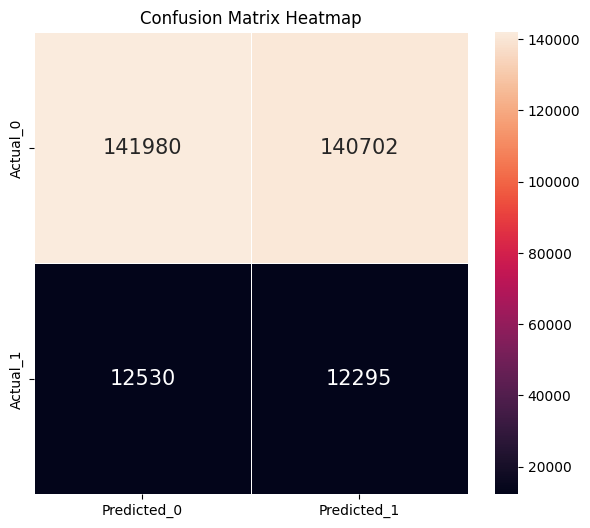

Distribution of Original Class Labels and Predicted Train and Test Class Labels


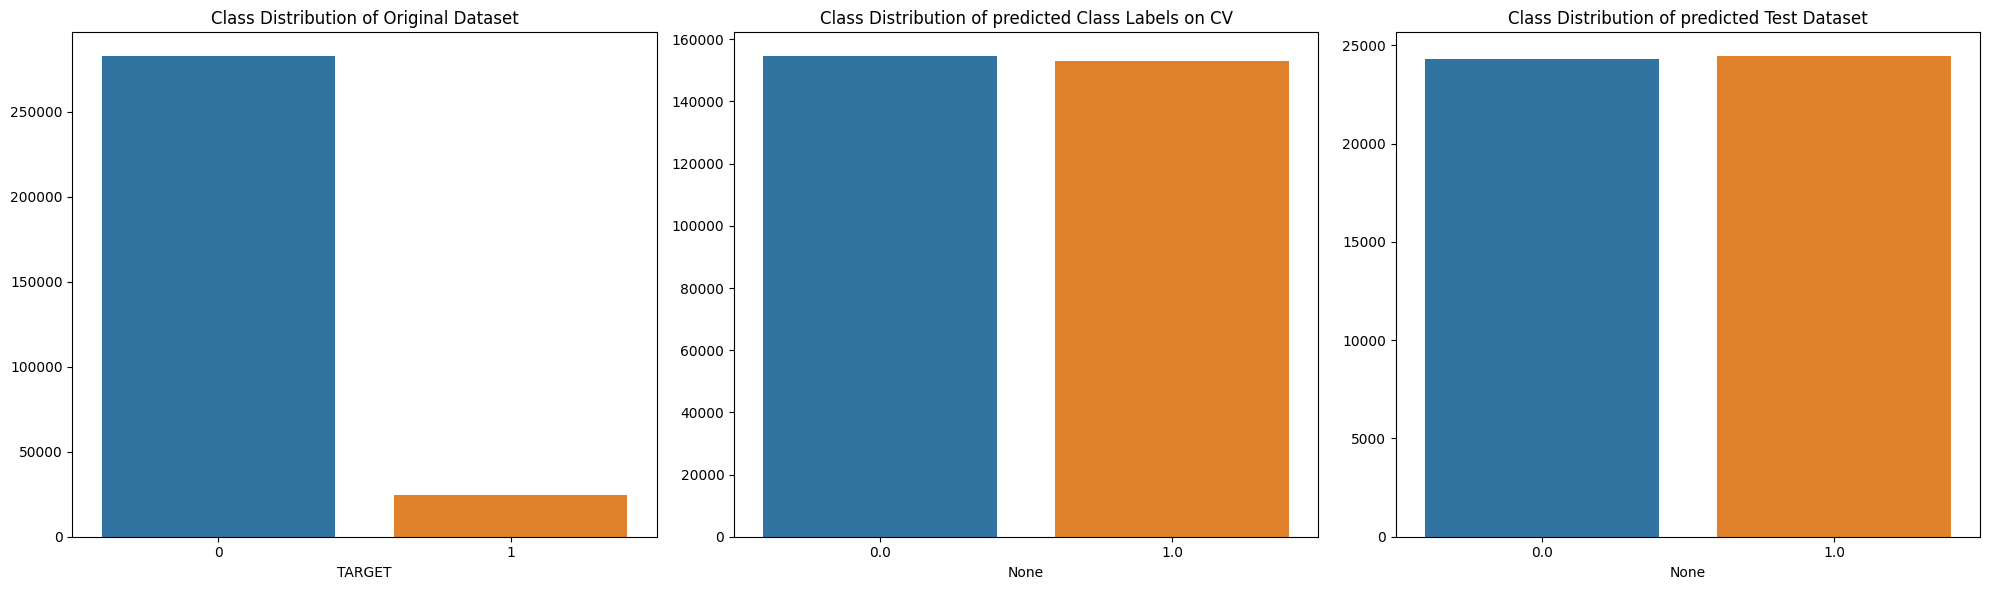

In [ ]:
#predicted proability for train and test datapoints
predicted_proba_train = np.random.uniform(0, 1, len(train_data))
predicted_proba_test = np.random.uniform(0, 1, len(test_data))

print("=" * 100)
print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

print("Confusion Matrix of Training data:")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print('=' * 100)

print("Distribution of Original Class Labels and Predicted Train and Test Class Labels")

# Calculate value counts beforehand to potentially speed up plotting
target_train_counts = target_train.value_counts()
predicted_proba_train_rounded = np.round(predicted_proba_train)
predicted_proba_train_counts = pd.Series(predicted_proba_train_rounded).value_counts()
predicted_proba_test_rounded = np.round(predicted_proba_test)
predicted_proba_test_counts = pd.Series(predicted_proba_test_rounded).value_counts()
colors_ = ['#1f77b4', '#ff7f0e']

plt.figure(figsize = (20,6))

plt.subplot(1,3,1)
plt.title('Class Distribution of Original Dataset')
# Use the pre-calculated counts
sns.barplot(x=target_train_counts.index, y=target_train_counts.values,palette=colors_)

plt.subplot(1,3,2)
plt.title('Class Distribution of predicted Class Labels on CV')
# Use the pre-calculated counts
sns.barplot(x=predicted_proba_train_counts.index, y=predicted_proba_train_counts.values,palette=colors_)

plt.subplot(1,3,3)
plt.title('Class Distribution of predicted Test Dataset')
# Use the pre-calculated counts
sns.barplot(x=predicted_proba_test_counts.index, y=predicted_proba_test_counts.values,palette=colors_)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()
print('=' * 100)

<ul><li>À partir de la matrice de confusion ci-dessus, nous constatons que le modèle prédit un nombre quasiment égal d’étiquettes de classes positives et négatives. Cela traduit une totale aléa du modèle.
<li>Cette même tendance se retrouve également dans la distribution des étiquettes de classes prédites.
<li>L’AUC du modèle aléatoire sur le jeu d’entraînement est proche de 0,5, et le score F1 avoisine les 0,14.
<li> Une AUC similaire est observée sur le jeu de test, comme indiqué dans la soumission précédente
<li>Cela fixe une baseline (référence) pour tous les métriques utilisées ici.</ul>

## Dominant Class Model

<li>Dans ce modèle, nous prédirons tout comme appartenant à la classe dominante, qui est ici la classe 0. Nous observerons aussi les métriques pour ce modèle, et encore une fois, nos modèles sérieux devront faire mieux.
<li>Puisque nous calculons également la valeur ROC-AUC, nous prédirons aléatoirement une probabilité comprise entre 0 et 0.5 avec un seuil à 0.5, de sorte que tous les points soient classés en 0.

Training Dataset Results:
	ROC-AUC Score = 0.49617102939885693
	Precision Score = 0.0
	Recall Score = 0.0
Confusion Matrix of Training data:


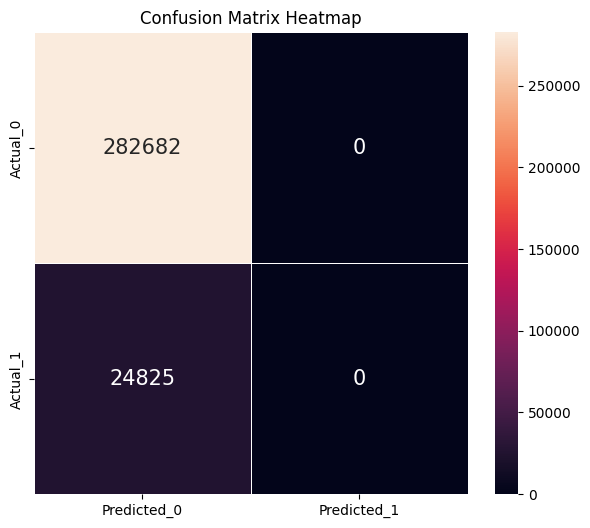

Distribution of Original Class Labels and Predicted Train and Test Class Labels


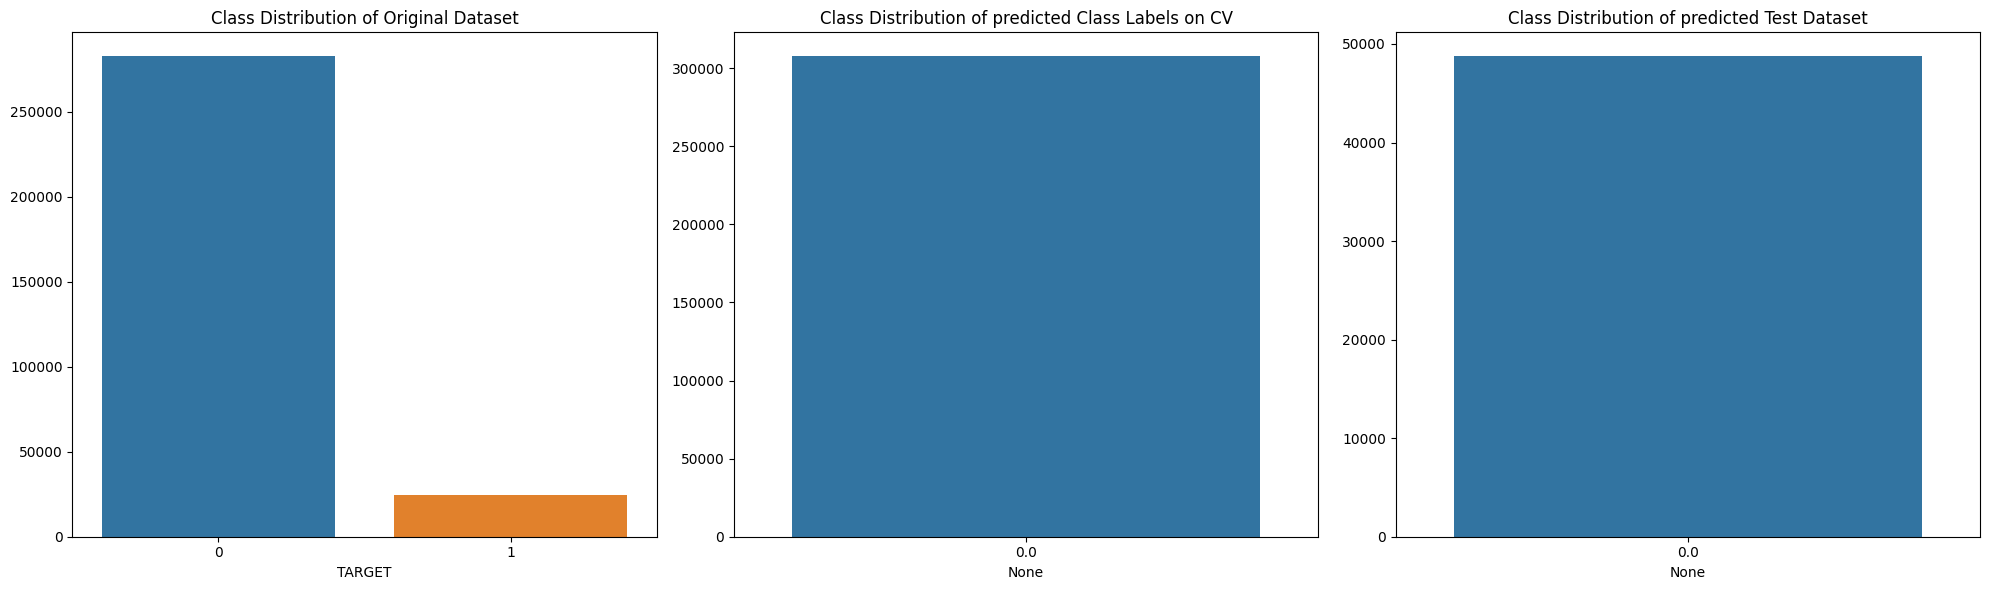

In [ ]:
#predicting everything with probability less than 0.5, i.e majority class
predicted_proba_train = np.random.uniform(0, 0.5, len(train_data))
predicted_proba_test = np.random.uniform(0, 0.5, len(test_data))

print("=" * 100)
print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

print("Confusion Matrix of Training data:")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print('=' * 100)

print("Distribution of Original Class Labels and Predicted Train and Test Class Labels")
# Calculate value counts beforehand to potentially speed up plotting
target_train_counts = target_train.value_counts()
predicted_proba_train_rounded = np.round(predicted_proba_train)
predicted_proba_train_counts = pd.Series(predicted_proba_train_rounded).value_counts()
predicted_proba_test_rounded = np.round(predicted_proba_test)
predicted_proba_test_counts = pd.Series(predicted_proba_test_rounded).value_counts()
colors_ = ['#1f77b4', '#ff7f0e']

plt.figure(figsize = (20,6))

plt.subplot(1,3,1)
plt.title('Class Distribution of Original Dataset')
# Use the pre-calculated counts
sns.barplot(x=target_train_counts.index, y=target_train_counts.values,palette=colors_)

plt.subplot(1,3,2)
plt.title('Class Distribution of predicted Class Labels on CV')
# Use the pre-calculated counts
sns.barplot(x=predicted_proba_train_counts.index, y=predicted_proba_train_counts.values,palette=colors_)

plt.subplot(1,3,3)
plt.title('Class Distribution of predicted Test Dataset')
# Use the pre-calculated counts
sns.barplot(x=predicted_proba_test_counts.index, y=predicted_proba_test_counts.values,palette=colors_)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()
print('=' * 100)

<li>D’après les résultats ci-dessus, nous constatons que l’AUC reste à peu près la même, soit 0.5.
<li>Cependant, le score F1 est maintenant nul, car aucune prédiction n’est faite pour la classe positive.
<li>La matrice de confusion montre également que tous les points sont classés comme négatifs, c’est-à-dire un grand nombre de faux négatifs, mais aucun faux positif.
<li>L’AUC sur le jeu de test est également cohérente avec celle de l’entraînement, soit 0.5074.

## Logistic Regression L2 Regularization

<li>Dans cette section, nous utiliserons le SGDClassifier avec la fonction de perte log-loss et la pénalité L2. Nous utiliserons GridSearchCV pour l’optimisation des hyperparamètres.</li>
<li>Nous n’avons pas encore divisé les données en ensemble d’entraînement et de validation croisée. Nous créerons les données de validation croisée à la volée, c’est-à-dire pendant l’optimisation des hyperparamètres.</li>
<li>Pour les prédictions globales sur la validation croisée, nous utiliserons la méthode Stratified K-Fold avec des prédictions de type Out-of-fold.</li>
<li>Comme nous optimisons les hyperparamètres sur l’AUC et que nous sommes dans un cas de dataset déséquilibré, nous ajusterons le seuil pour obtenir le meilleur TPR et le TPR le plus faible, en utilisant la statistique J (J-Statistic).</li>

Doing Randomized Search CV on Classifier with 15 random initializations...
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Done.
Time elapsed = 0:10:19.072856


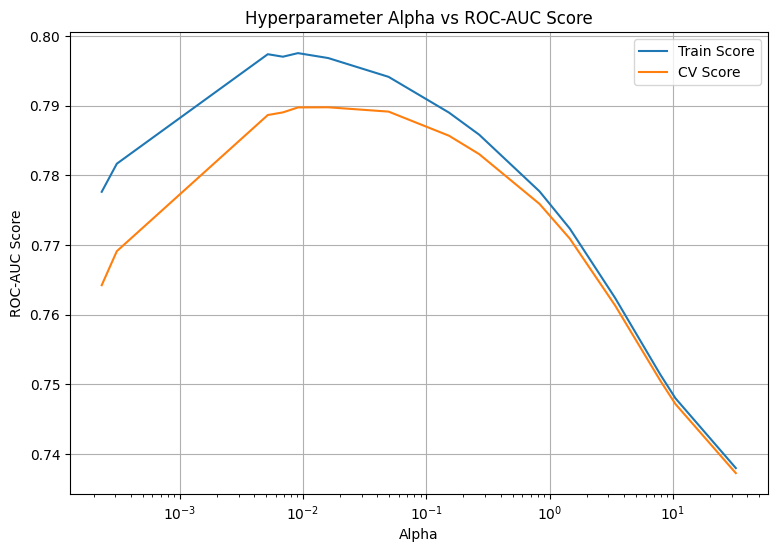

In [ ]:
params = {
    'loss' : 'log_loss',
    'penalty' : 'l2',
    'random_state' : 98,
    'class_weight' : 'balanced',
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {'alpha' : np.logspace(-4,2)}

sgd_lr_l2 = modelling(clf, x_train_std, y_train, x_test_std)

#lets do randomized search cv first
sgd_lr_l2.random_search_cv(hyperparams, n_iter = 15, n_jobs = 2)

#visualizing the cv results
cv_results = sgd_lr_l2.tuning_results
cv_results = cv_results.sort_values('param_alpha')

#plotting the train and cv scores
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Train Score')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'CV Score')
plt.title('Hyperparameter Alpha vs ROC-AUC Score')
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:01:19.235456

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.47930005748012217

Train Results:
	ROC-AUC Score = 0.7962304882808865
	Precision Score = 0.1817542539072559
	Recall Score = 0.739214501510574
CV Results:
	ROC-AUC Score = 0.7897156648281627
	Precision Score = 0.17957995673973068
	Recall Score = 0.7257200402819738
Confusion Matrix of CV data:


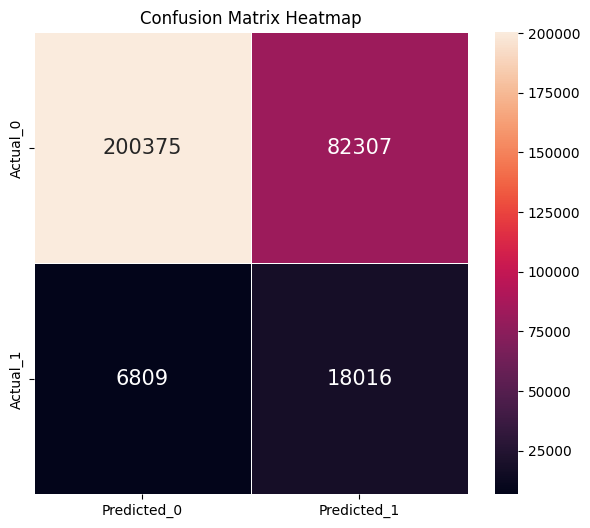

Distribution of Original Class Labels and Predicted CV and Test Class Labels


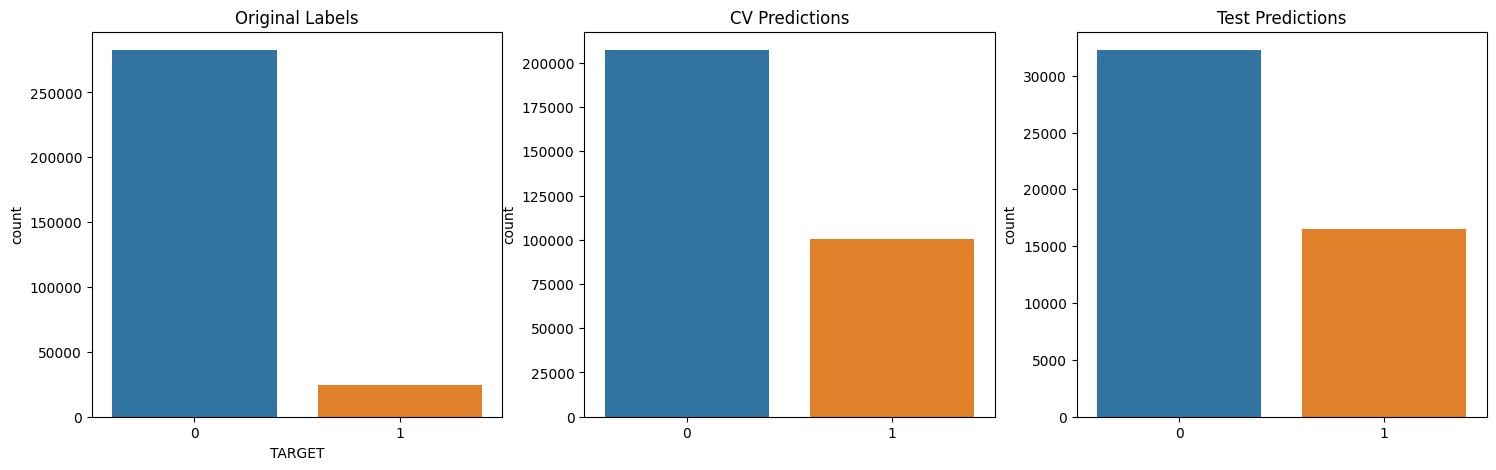

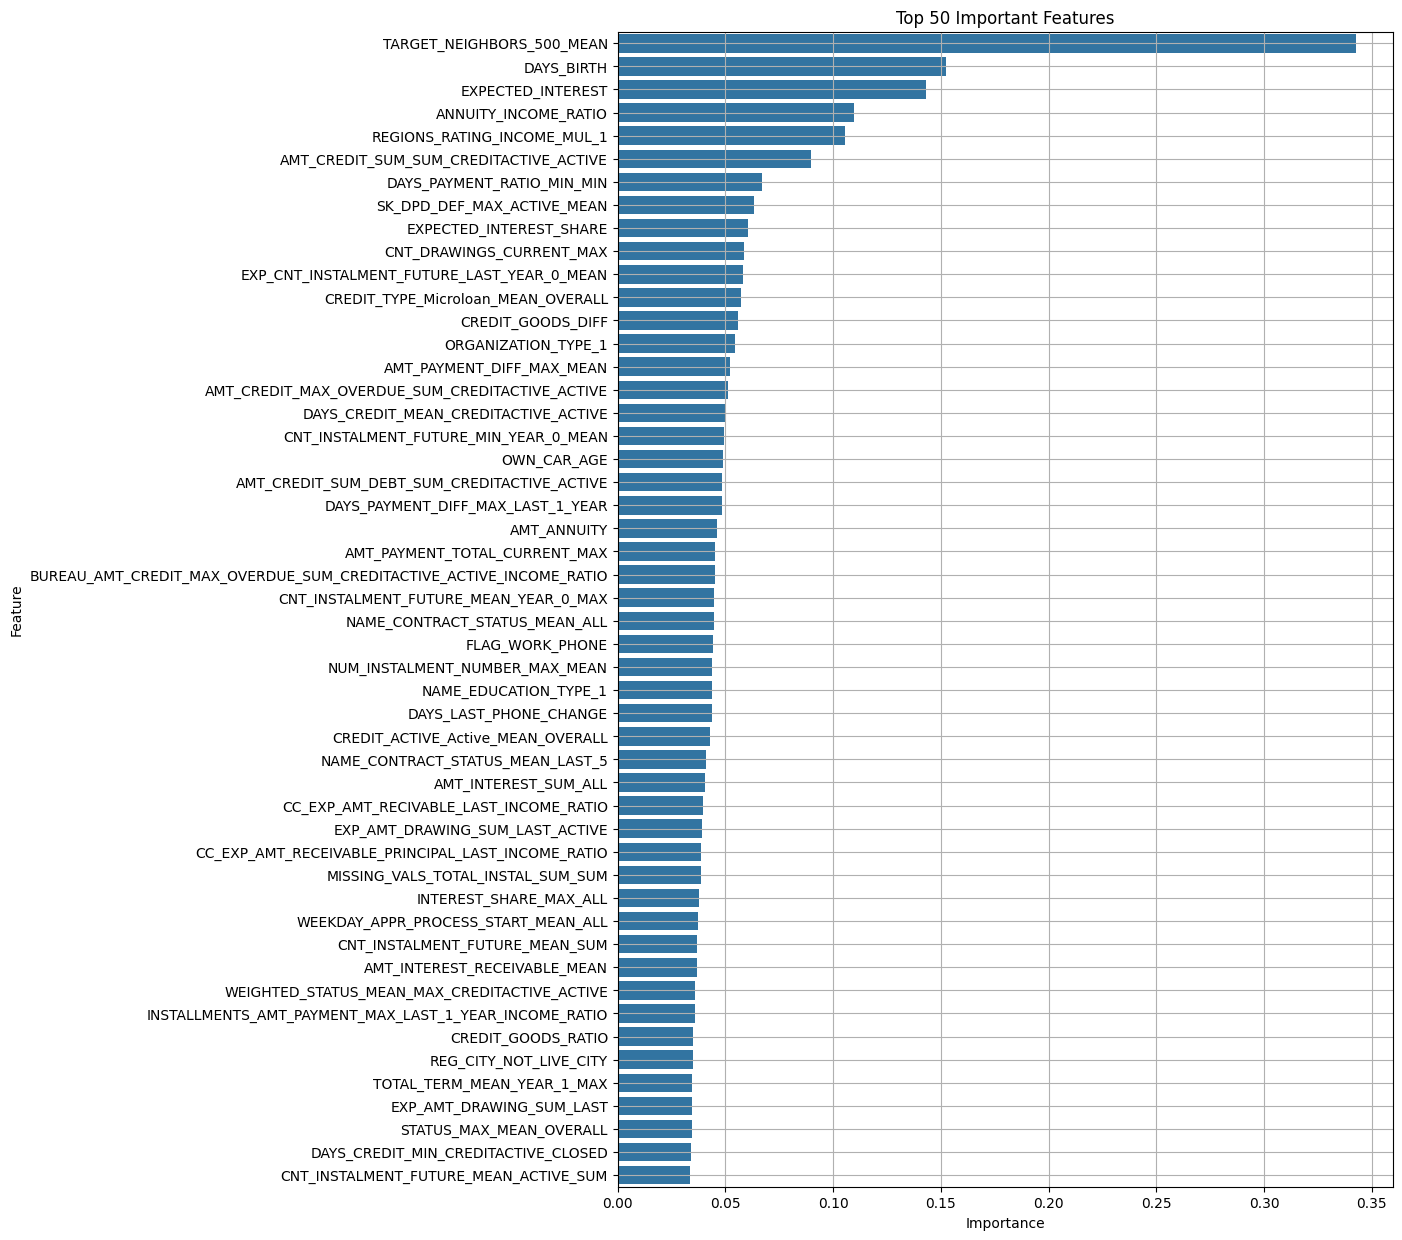

In [ ]:
#training on best parameters
sgd_lr_l2.train_on_best_params()
#showing the results
sgd_lr_l2.results_on_best_params('linear')
#plotting feature importances
sgd_lr_l2.feat_importances_show(train_data.columns, num_features = 50)

In [ ]:
with open('SGD_LR_L2_Penalty_CV_Preds.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.cv_preds_probas, f)
with open('SGD_LR_L2_Penalty_Test_Preds.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.test_preds_probas, f)
with open('SGD_LR_L2_Penalty_Model.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.best_model, f)

<b>Discussion des résultats</b>

<ul>
    <li>Nous avons d'abord ajusté l'hyperparamètre 'alpha' pour la régression logistique en utilisant RandomizedSearchCV, avec une validation croisée à 4 plis.</li>
    <li>Nous avons ensuite utilisé le meilleur modèle obtenu pour l'entraîner sur le jeu de données d'entraînement.</li>
    <ul>
        <li>À partir des scores AUC, nous voyons que les scores AUC sur l'entraînement et la validation croisée sont très proches l’un de l’autre. Cela implique qu’il n’y a pas beaucoup de surapprentissage.</li>
        <li>Le seuil optimal de décision pour la probabilité est de 0,47, ce qui est proche de 0,5. Cela s’explique par le fait que la régression logistique renvoie intrinsèquement une probabilité réelle de classe.</li>
        <li>La matrice de confusion montre qu’il y a beaucoup de faux positifs, tandis que le nombre de faux négatifs est en réalité plus faible.</li>
        <li>Nous constatons que la précision de notre modèle est très faible. Cependant, le rappel est plutôt bon. C’est ce que nous souhaitons : aucun défaut ne doit être manqué, même si certains non-défaillants sont classés comme défaillants, car ils peuvent refaire une demande, mais si un défaillant n’est pas détecté, cela pourrait entraîner de lourdes pertes pour l’entreprise.</li>
        <li>En observant la distribution des classes prédites par rapport aux classes réelles, nous remarquons que beaucoup plus de classes positives sont prédites qu’il n’y en a réellement. Cela confirme la faible précision.</li>
        <li>Nous constatons également que la distribution des classes prédites  est très similaire entre les jeux de données CV et test, ce qui implique que le modèle fonctionne de manière comparable sur ces deux jeux.</li>
        <li>Nous avons tracé les 50 principales variables selon le classificateur. La variable la plus importante est la moyenne des valeurs cibles des 500 voisins. Nous voyons aussi qu’une autre variable créée, à savoir l’intérêt attendu, obtient un score élevé. Cela signifie que nos variables générées contribuent réellement à la tâche de classification.</li>
    </ul>
</ul>

        


## Linear SVM

Dans cette section, nous entraînerons à nouveau un SGDClassifier avec une pénalité L2 mais cette fois avec la fonction de perte hinge, correspondant à un SVM linéaire. Nous n’utiliserons pas de SVM à noyau en raison de la complexité élevée du temps d’entraînement, étant donné que le nombre de points de données est très important dans notre cas.

Doing Randomized Search CV on Classifier with 15 random initializations...
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Done.
Time elapsed = 0:14:36.372982


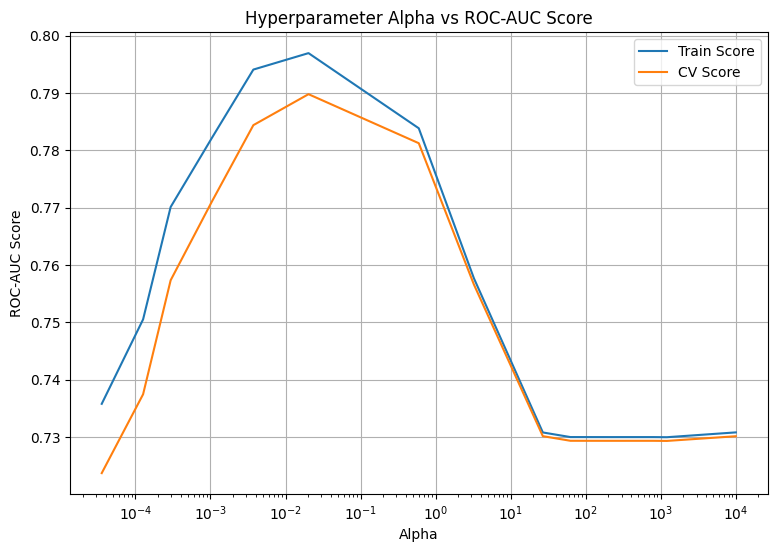

In [ ]:
params = {
    'loss' : 'hinge',
    'class_weight' : 'balanced',
    'random_state' : 129,
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {
    'alpha' : np.logspace(-5,4)
}
linear_svm = modelling(clf, x_train_std, y_train, x_test_std, calibration = True)

#lets do randomized search cv first
linear_svm.random_search_cv(hyperparams, n_iter = 15, n_jobs = 2, random_state = 693)

#visualizing the cv results
cv_results = linear_svm.tuning_results
cv_results = cv_results.sort_values('param_alpha')

#plotting the train and cv scores
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Train Score')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'CV Score')
plt.title('Hyperparameter Alpha vs ROC-AUC Score')
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:06:01.680730

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.08025409148866137

Train Results:
	ROC-AUC Score = 0.7973773876756229
	Precision Score = 0.182017435114201
	Recall Score = 0.7392950654582074
CV Results:
	ROC-AUC Score = 0.7907495790589881
	Precision Score = 0.17940592886546036
	Recall Score = 0.7320845921450151
Confusion Matrix of CV data:


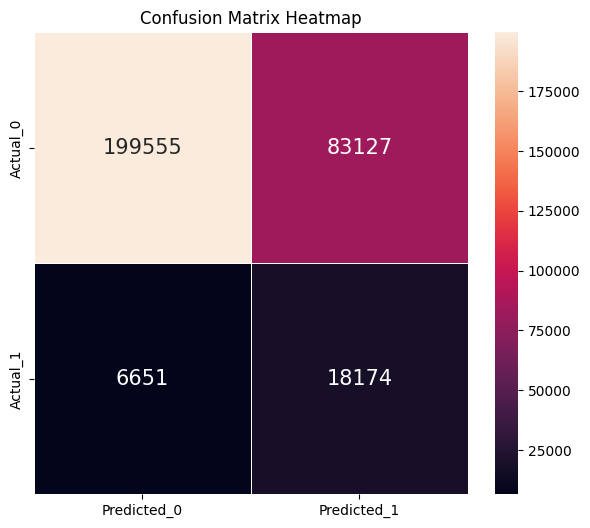

Distribution of Original Class Labels and Predicted CV and Test Class Labels


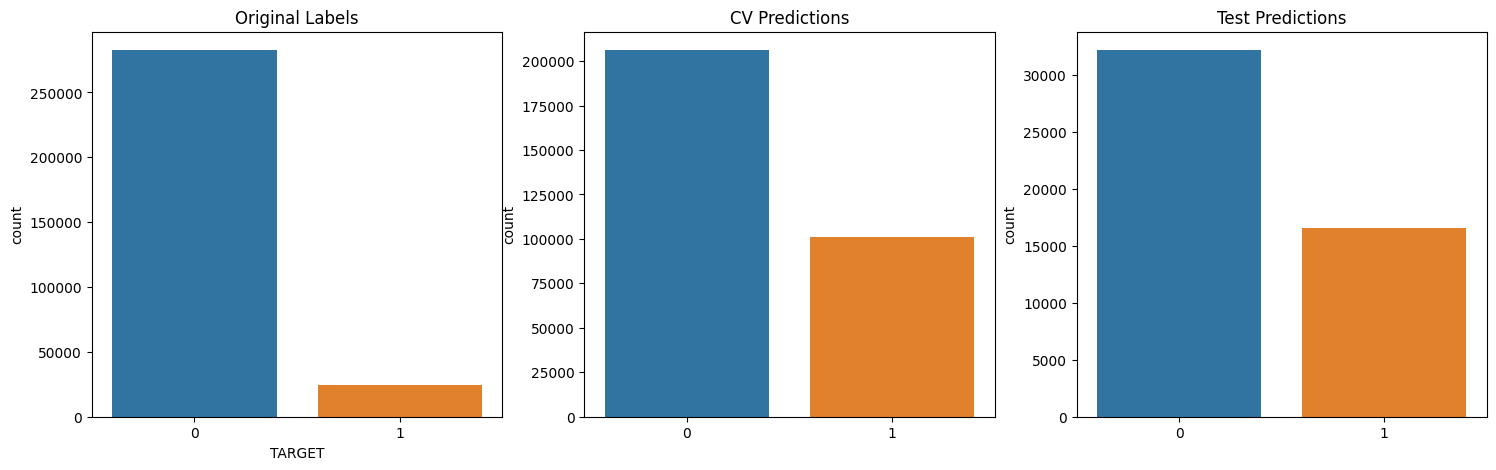

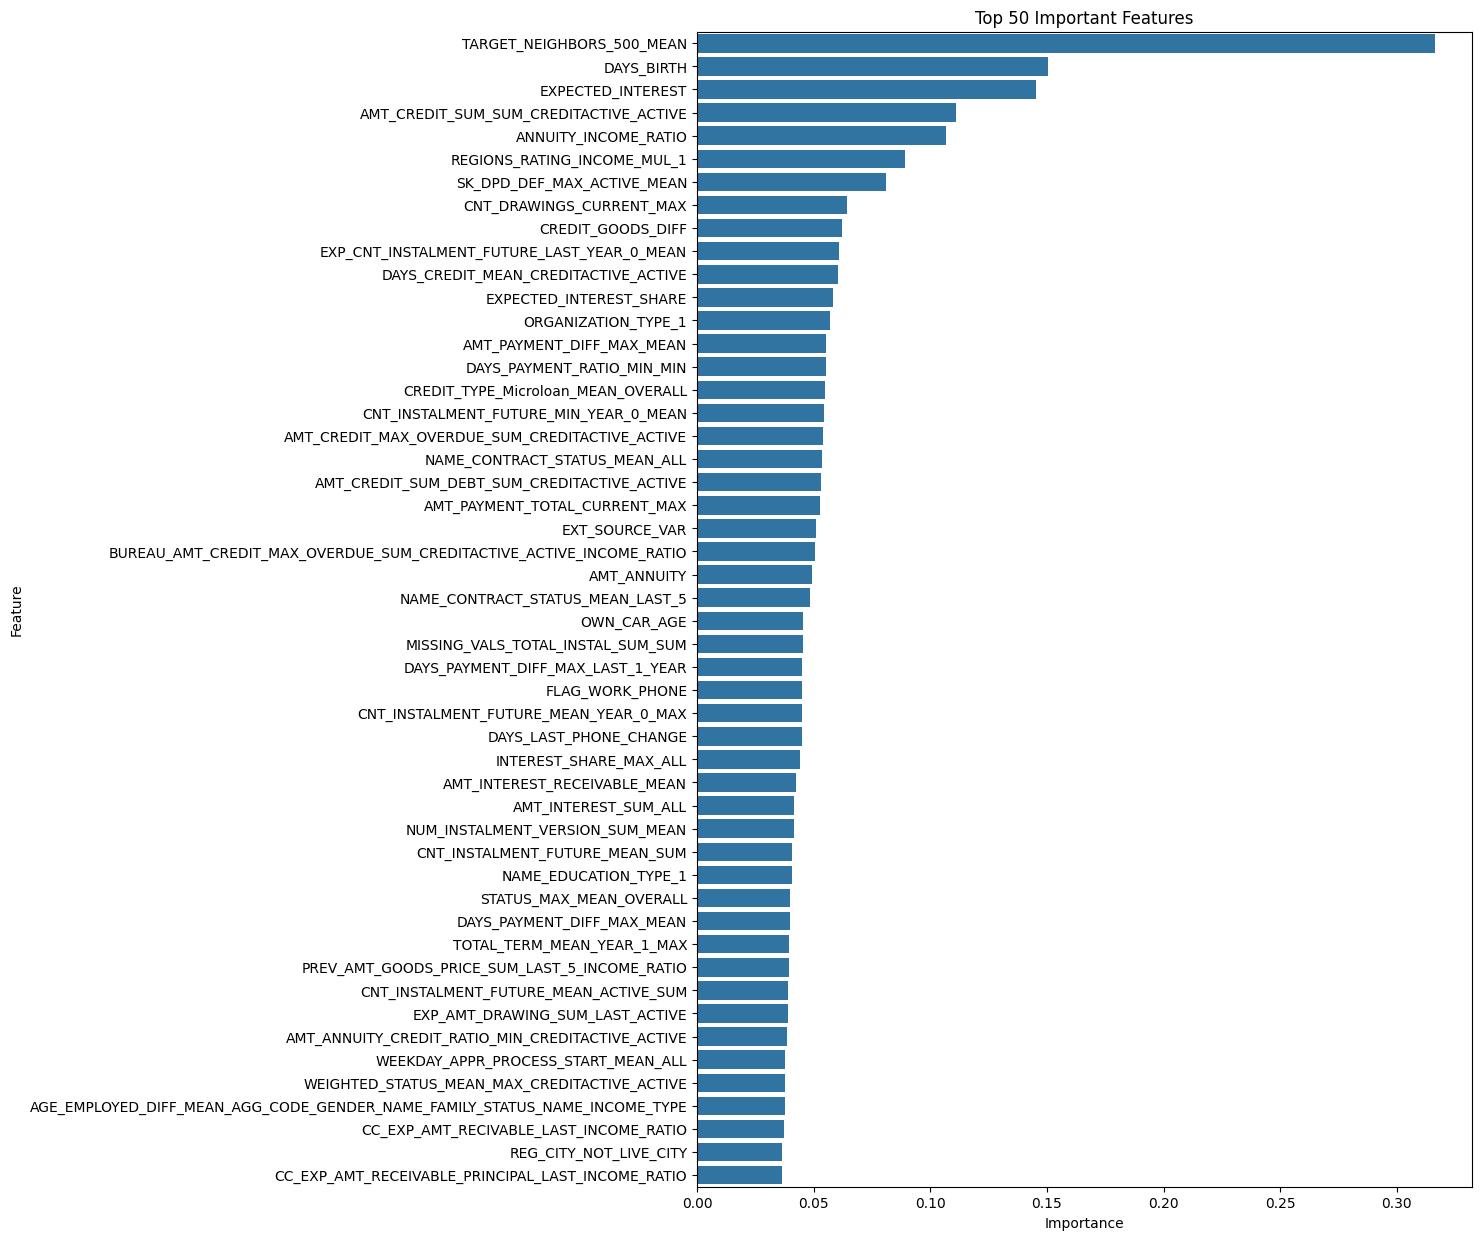

In [ ]:
#training on best parameters
linear_svm.train_on_best_params()
#showing the results
linear_svm.results_on_best_params('linear')
#plotting feature importances
linear_svm.feat_importances_show(train_data.columns, num_features = 50)

In [ ]:
with open('SGD_Linear_SVM_CV_Preds.pkl', 'wb') as f:
    pickle.dump(linear_svm.cv_preds_probas, f)
with open('SGD_Linear_SVM_Test_Preds.pkl', 'wb') as f:
    pickle.dump(linear_svm.test_preds_probas, f)
with open('SGD_Linear_SVM_Model.pkl', 'wb') as f:
    pickle.dump(linear_svm.best_model, f)

<b>Discussion des résultats</b>

<ol>
    <li>Les résultats du SVM linéaire sans formulation duale sont très similaires à ceux de la régression logistique. Cependant, on note une très légère amélioration des performances.</li>
    <li>Les scores AUC d'entraînement et de validation croisée pour le SVM linéaire sont légèrement supérieurs à ceux de la régression logistique. Il en va de même pour l’AUC sur le jeu de test, selon Kaggle.</li>
    <li>Un point intéressant à noter est que le seuil de probabilité optimal est aussi bas que 0,08.</li>
    <li>Les valeurs de précision et de rappel sont quasiment identiques, bien que légèrement supérieures pour la régression logistique.</li>
    <li>À partir de la matrice de confusion, on remarque que le nombre de vrais positifs pour le SVM linéaire est légèrement inférieur à celui de la régression logistique.</li>
    <li>Les 50 variables les plus importantes sont également presque identiques à celles de la régression logistique.</li>
</ol>

Ainsi, nous pouvons conclure que la régression logistique et le SVM linéaire se comportent de manière très similaire, comme prévu.


## Random Forest Classifier

Dans cette section, nous utiliserons la technique de Bagging et entraînerons un classificateur Random Forest. Nous appliquerons la méthode de recherche aléatoire (Randomized Search) pour ajuster certains hyperparamètres du RandomForestClassifier.

In [ ]:
params = {
    'n_jobs' : -1,
    'random_state' : 210,
    'class_weight' : 'balanced_subsample',
    'verbose' : 0
}
clf = RandomForestClassifier(**params)
hyperparams = {
    'n_estimators' : list(range(500, 1500)),
    'max_depth' : list(range(10,30)),
    'min_samples_split' : list(range(5,20)),
    'min_samples_leaf' : list(range(2,20)),
    'max_samples' : uniform(0,1)
}

rf = modelling(clf, x_train_std, y_train, x_test_std)

#lets do randomized search cv first
rf.random_search_cv(hyperparams, n_iter = 10, n_jobs = -1, random_state = 4281)

Doing Randomized Search CV on Classifier with 10 random initializations...
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Done.
Time elapsed = 11:09:43.277827


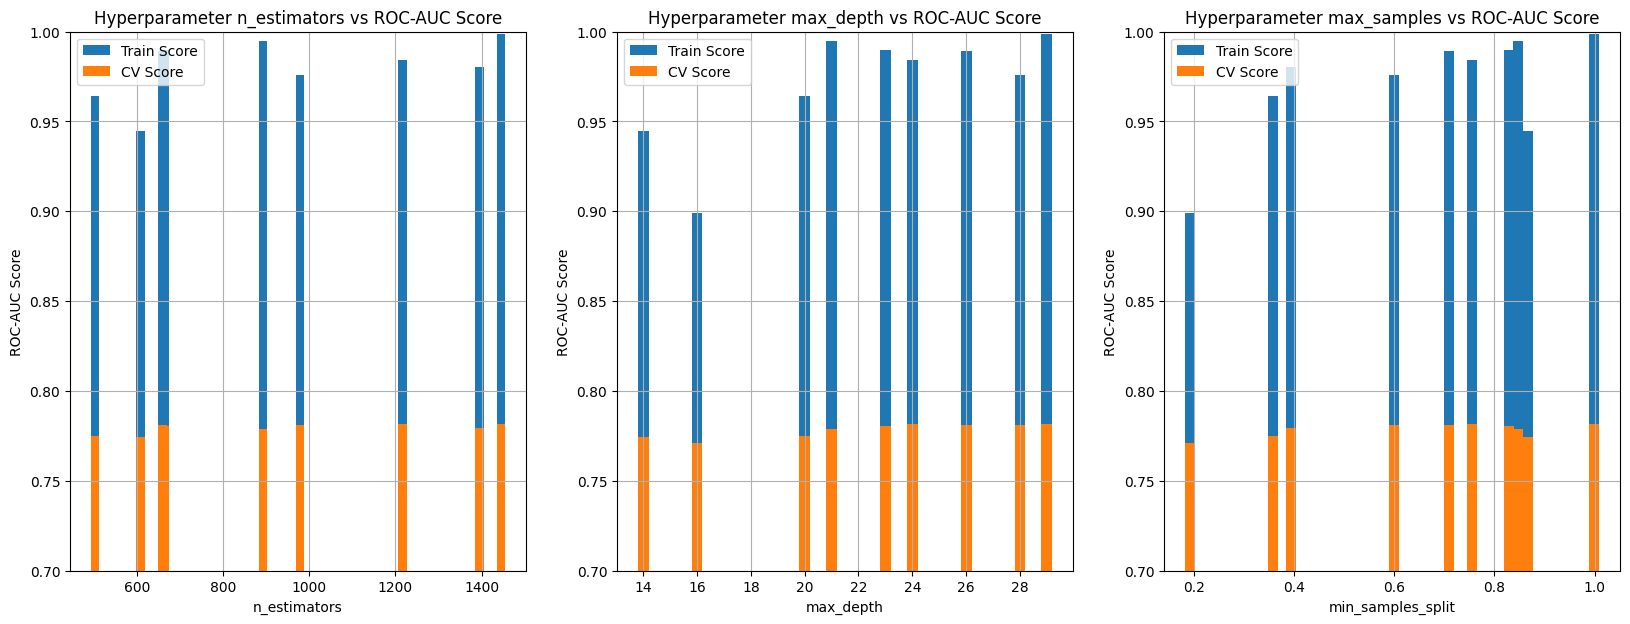

In [ ]:
cv_results = rf.tuning_results

#lets plot the ROC-AUC for different Hyperparameters
plt.figure(figsize = (20,7))
plt.subplot(1,3,1)
cv_results = cv_results.sort_values('param_n_estimators')
plt.bar(cv_results['param_n_estimators'], cv_results['mean_train_score'], width = 20, label = 'Train Score')
plt.bar(cv_results['param_n_estimators'], cv_results['mean_test_score'], width = 20, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter n_estimators vs ROC-AUC Score')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
cv_results = cv_results.sort_values('param_max_depth')
plt.bar(cv_results['param_max_depth'], cv_results['mean_train_score'], width = 0.4, label = 'Train Score')
plt.bar(cv_results['param_max_depth'], cv_results['mean_test_score'], width = 0.4, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter max_depth vs ROC-AUC Score')
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
cv_results = cv_results.sort_values('param_min_samples_split')
plt.bar(cv_results['param_max_samples'], cv_results['mean_train_score'], width = 0.02, label = 'Train Score')
plt.bar(cv_results['param_max_samples'], cv_results['mean_test_score'], width = 0.02, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter max_samples vs ROC-AUC Score')
plt.xlabel('min_samples_split')
plt.ylabel('ROC-AUC Score')

plt.legend()
plt.grid()
plt.show()

D’après les graphiques ci-dessus, nous constatons que les paramètres avec le plus haut ROC-AUC en validation croisée ont également un score ROC-AUC très élevé en entraînement. Pour éviter un surapprentissage, nous allons donc choisir des paramètres présentant un écart raisonnable entre les scores d’entraînement et de validation croisée.

In [ ]:
cv_results['Train_CV_Score_Difference'] = cv_results['mean_train_score'] - cv_results['mean_test_score']

#lets look at the differences between the train and CV scores
print("Checking out the differences between Train and CV Scores for each set of hyperparameters:\n")
display(cv_results[['params', 'mean_test_score', 'mean_train_score', 'Train_CV_Score_Difference']])

Checking out the differences between Train and CV Scores for each set of hyperparameters:



,params,mean_test_score,mean_train_score,Train_CV_Score_Difference
3,"{'max_depth': 29, 'max_samples': 0.99942209291...",0.781834,0.998494,0.216660
7,"{'max_depth': 21, 'max_samples': 0.84676766673...",0.778950,0.994705,0.215756
9,"{'max_depth': 26, 'max_samples': 0.39390409715...",0.779579,0.980412,0.200833
6,"{'max_depth': 26, 'max_samples': 0.70868250450...",0.780756,0.989346,0.208591
4,"{'max_depth': 24, 'max_samples': 0.75490714257...",0.781323,0.984387,0.203064
5,"{'max_depth': 28, 'max_samples': 0.60002385073...",0.780945,0.976053,0.195108
2,"{'max_depth': 16, 'max_samples': 0.19140070731...",0.771224,0.899231,0.128007
0,"{'max_depth': 20, 'max_samples': 0.35680763572...",0.774931,0.963881,0.188951
8,"{'max_depth': 23, 'max_samples': 0.82887645113...",0.780709,0.989997,0.209289
1,"{'max_depth': 14, 'max_samples': 0.86734516973...",0.774507,0.944785,0.170278


Nous observons que l’écart minimum entre le score d’entraînement et celui de la validation croisée est de 0,054660, et que le score de validation croisée n’est pas non plus trop faible. Nous choisirons donc cet ensemble d’hyperparamètres.

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:16:26.507412

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.31434583146933576

Train Results:
	ROC-AUC Score = 0.8319865087692295
	Precision Score = 0.18981516768292683
	Recall Score = 0.8025377643504532
CV Results:
	ROC-AUC Score = 0.7762964914411066
	Precision Score = 0.17134265667509904
	Recall Score = 0.7230211480362537
Confusion Matrix of CV data:


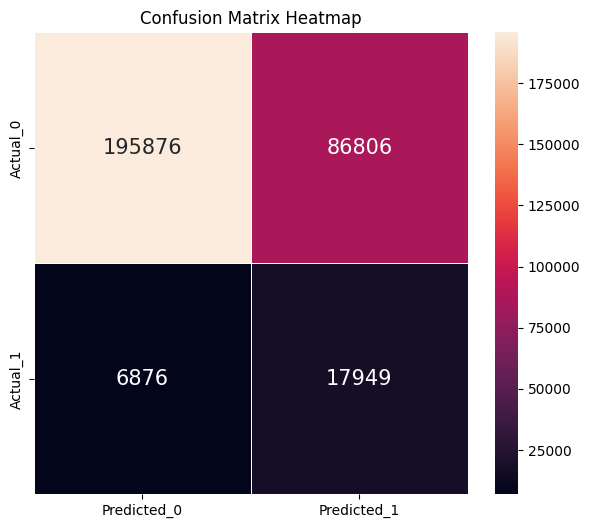

Distribution of Original Class Labels and Predicted CV and Test Class Labels


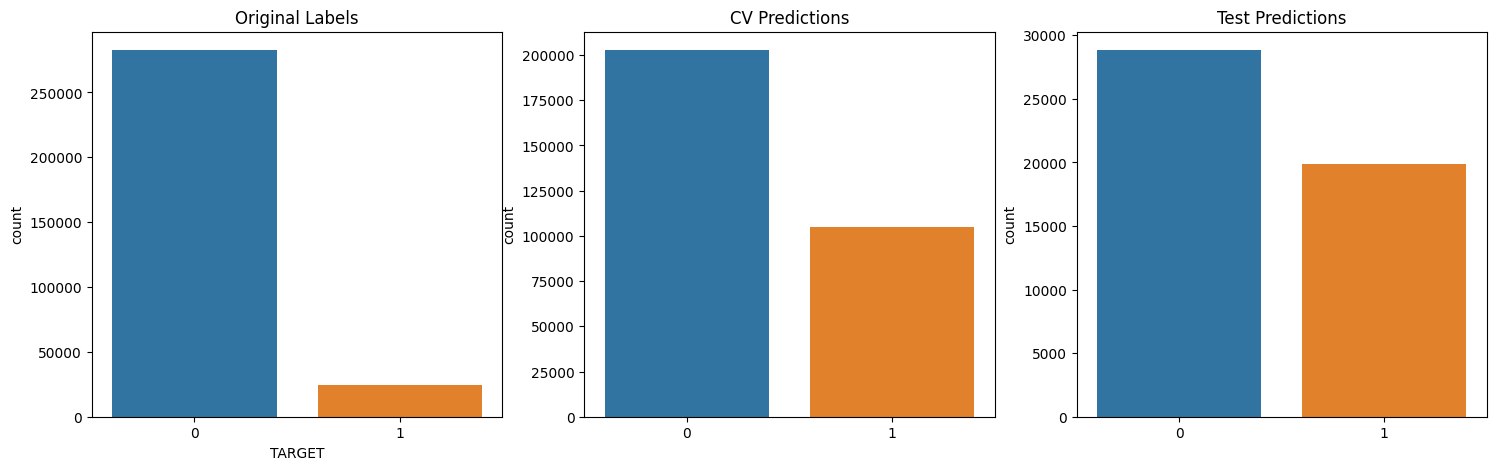

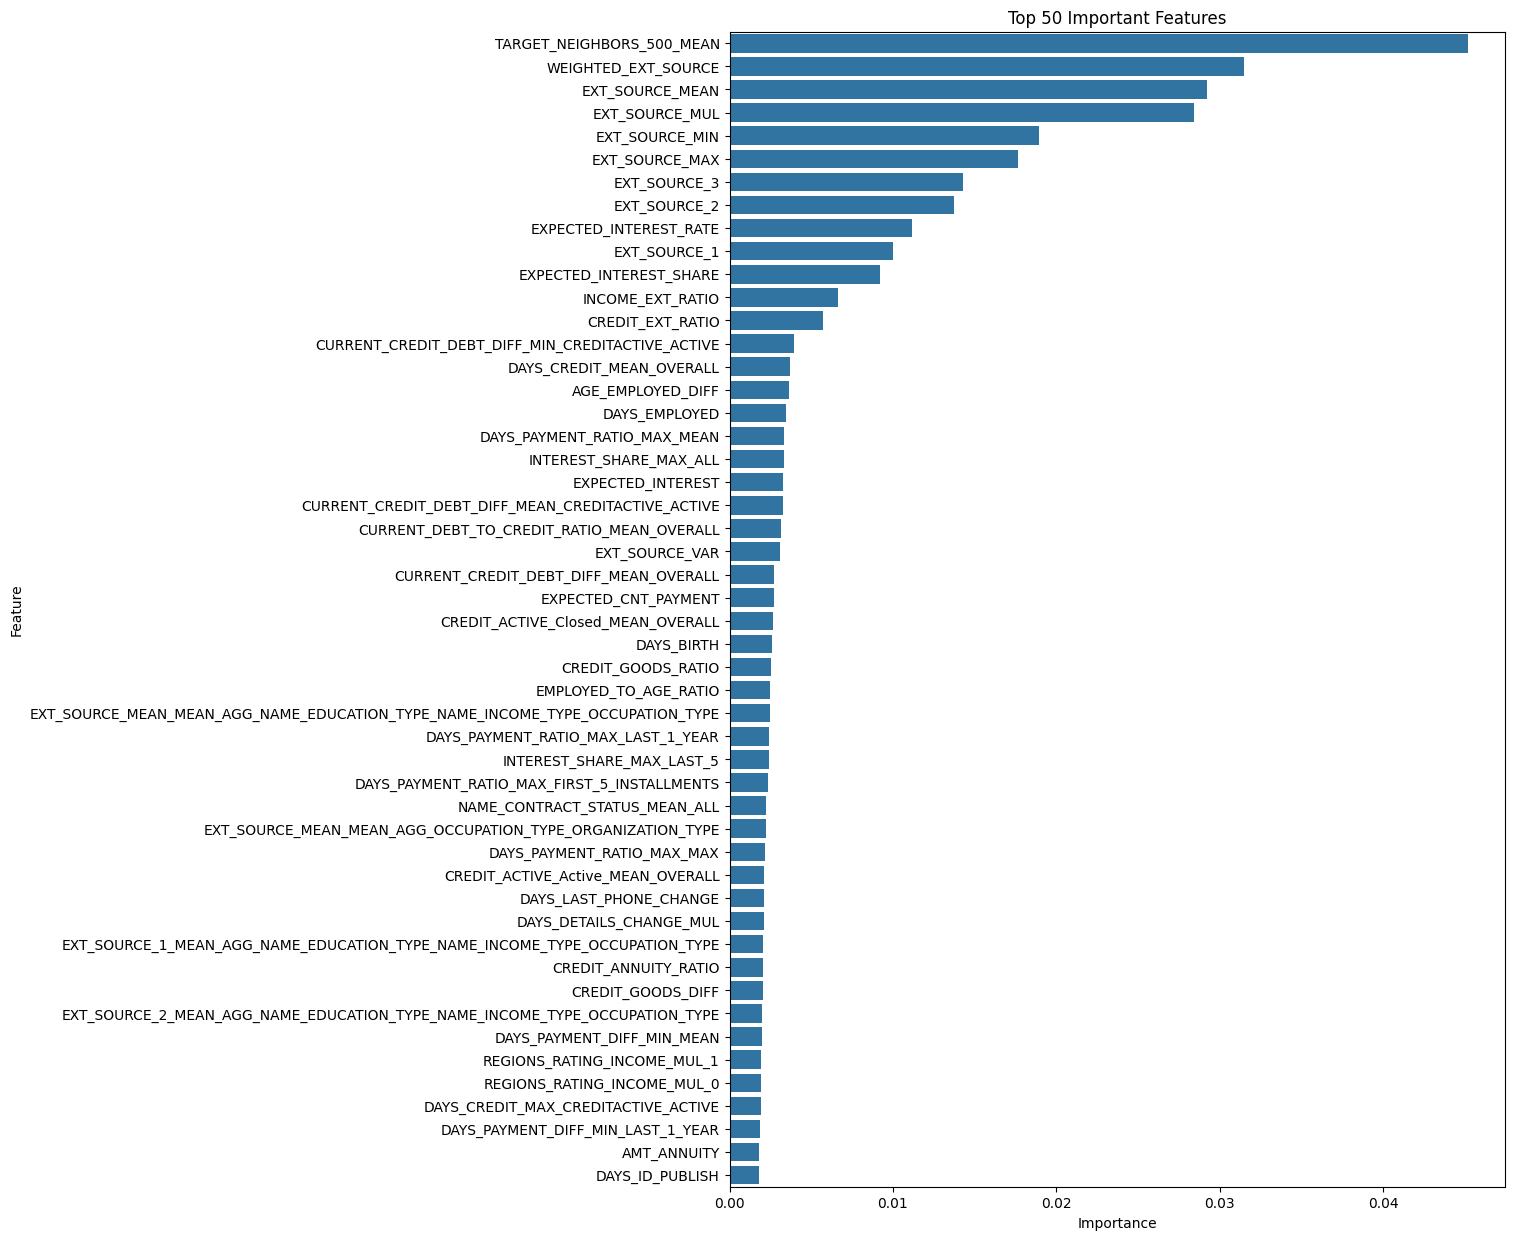

In [ ]:
#reinstantiating the best model of rf class with these parameters
rf.best_model = RandomForestClassifier(class_weight = 'balanced_subsample', max_depth = 19,
                                       max_samples = 0.105493, min_samples_leaf = 26,
                                       min_samples_split = 44, n_estimators = 1403, n_jobs = -1,
                                       random_state = 210, verbose = 0)
#training on best parameters
rf.train_on_best_params()
#showing the results
rf.results_on_best_params('random_forest')
#plotting feature importances
rf.feat_importances_show(train_data.columns, num_features = 50)

In [ ]:
import pickle
with open('/content/drive/MyDrive/Scoring-Projet/data/Random_Forest_CV_Preds.pkl', 'wb') as f:
    pickle.dump(rf.cv_preds_probas, f)

with open('/content/drive/MyDrive/Scoring-Projet/data/Random_Forest_Test_Preds.pkl', 'wb') as f:
    pickle.dump(rf.test_preds_probas, f)

with open('/content/drive/MyDrive/Scoring-Projet/data/Random_Forest_Model.pkl', 'wb') as f:
    pickle.dump(rf.best_model, f)

<b>Discussion des résultats</b>
<ul>
    <li>Il y a une grande différence entre les scores d’entraînement et de validation croisée, ce qui indique un fort surapprentissage.</li>
    <li>La matrice de confusion montre un nombre élevé de faux positifs, ce qui impacte négativement la précision. Cependant, le rappel est élevé, ce qui est bénéfique du point de vue métier.</li>
    <li>Les valeurs de rappel sur les données d’entraînement et de validation confirment ce fort surapprentissage.</li>
</ul>

<br>

Nous remarquons que la variable la plus importante est encore la moyenne de la cible (TARGET) des 500 voisins, comme pour la régression logistique et le SVM linéaire. Nous observons également que la plupart des variables EXT_SOURCE figurent parmi les plus importantes. Les variables générées à partir des données brutes EXT_SOURCE performent mieux que les variables brutes elles-mêmes.



# Final DataFrame with Reduced Features for Pipeline

Sur la base des caractéristiques éliminées ci-dessus, nous les retirerons des tables relationnelles, qui seront chargées en mémoire lors de la mise en production, afin d’être fusionnées avec les points de données principaux de application_test.

In [ ]:
# Execute the modified cell
relational_tables_prepare(file_directory='/content/drive/MyDrive/Scoring-Projet/data/')

Loading the tables into memory...
Done.

Merging all the tables, and saving to pickle file 'relational_table.pkl'...
Done.
Total Time taken = 0:01:44.768903
